## Explore and Calculate Metrics for ScanBank

Calculate metrics for ScanBank-processed files.

Because our definitions of figure/figure caption differ, don't apply post processing (probably).

In [44]:
from sys import path
path.append('../')
import config

# set a seed for CV comparision?  Set to None for random
seed = 5
n_folds_cv = 5

In [5]:
# do we want to save our results to .dat files for use in other areas (like tables in latex)
save_dats = True
#any extra tag to anything
adder_dats = ''
# which iou's to save?
#ioustar = [0.9] # fig, caption
ioustar = [0.8] # fig, caption
scorestar = 0.1
adder = ''


# # SCAN BANK -- test how well scanbank does on our images (the final test dataset)
# annotation_files = '/Users/jillnaiman/MegaYolo_test/yolo_512x512_ann/' 
# feature_dir = '/Users/jillnaiman/MegaYolo_test/binaries_model12_finaltest/'
####### pickle_file_loc = '/Users/jillnaiman/Dropbox/wwt_image_extraction/FigureLocalization/MetricsResults/'
# yolopicklename = 'binaries_model12_finaltest.pickle'
# images_jpeg_dir = '/Users/jillnaiman/Dropbox/wwt_image_extraction/FigureLocalization/Pages/RandomSingleFromPDFIndexed/' # default
# check_json_dir = None
# pdf_dir = ''


# SCAN BANK -- test how well scanbank does on *its own set of images from ETDs*
annotation_files = '/Users/jillnaiman/MegaYolo_scanbank/yolo_512x512_ann/' 
feature_dir = '/Users/jillnaiman/MegaYolo_scanbank/binaries_model12_scanbank/' # not really used I think?
#######pickle_file_loc = '/Users/jillnaiman/Dropbox/wwt_image_extraction/FigureLocalization/MetricsResults/'
yolopicklename = 'binaries_model12_scanbank.pickle' # also not sure if this is used?
images_jpeg_dir = '/Users/jillnaiman/Dropbox/wwt_image_extraction/FigureLocalization/BenchMarks/Pages_scanbank/RandomSingleFromPDFIndexed/'
check_json_dir = '/Users/jillnaiman/deepfigures-results/17' # check for empty json files? set to None to skip
pdf_dir = '/Users/jillnaiman/Dropbox/wwt_image_extraction/FigureLocalization/BenchMarks/data/scanbank/etds/'



# # which metric file?
# #binary_dirs = 'binaries_model12_tfrecordz_pmcnoncom/'
# binary_dirs = 'binaries_model12_finaltest/' # final, final test

# use_valid = False





# # pp2 = '/Users/jillnaiman/Dropbox/wwt_image_extraction/FigureLocalization/MetricsResults/binaries_model12_finaltest.pickle'
# # images_jpeg_dir = None
# # adder_here = ''

# # test how well detectron2 does on our images
# pp2 = '/Users/jillnaiman/Dropbox/wwt_image_extraction/FigureLocalization/MetricsResults/binaries_model12_finaltest_fbdetect.pickle'
# images_jpeg_dir = None
# adder_here = 'fbdetect'
# ocr_results_dir = None
# save_binary_dir = '/Users/jillnaiman/MegaYolo_test/'
# full_article_pdfs_dir = None
# make_sense_dir = '/Users/jillnaiman/Dropbox/wwt_image_extraction/FigureLocalization/Annotations/MakeSenseAnnotations_test/'
# ###binary_dirs = 'binaries_model12_finaltest/'# for final test set



# # pp2 = '/Users/jillnaiman/Dropbox/wwt_image_extraction/FigureLocalization/MetricsResults/binaries_model12_tfrecordz_pmcnoncom_fbdetect.pickle'
# # images_jpeg_dir = '/Users/jillnaiman/Dropbox/wwt_image_extraction/FigureLocalization/BenchMarks/Pages_pmcnoncom/RandomSingleFromPDFIndexed/'
# # adder_here = 'pmcnon'




# #adder_dats = 'fbdetect_noncom2'



In [49]:
deepfiguresDir = '/Users/jillnaiman/deepfigures-results/' # where results are found from ScanBank

sbann_dir = '/Users/jillnaiman/Dropbox/wwt_image_extraction/FigureLocalization/BenchMarks/data/scanbank/annotations.json' # scanbank annotation's file

In [4]:
from glob import glob
if check_json_dir is not None:
    missingFiles = []
    jfiles = glob(check_json_dir + '*')
    for jf in jfiles:
        fs = glob(jf+'/*')
        fs = glob(fs[0]+'/*')
        hasJson = False
        for f in fs:
            if 'results.json' in f:
                hasJson = True
        if not hasJson:
            missingFiles.append(jf)
    # write missing to file
    if len(missingFiles) > 0:
        with open(pdf_dir+'testList_missing.csv','w') as fi:
            for m in missingFiles:
                print('/'+m.split('/')[-1]+'_p',file=fi) # weird formatting
    print('there are:', len(missingFiles), 'missing files')

there are: 16 missing files


In [21]:
import pickle
from sys import path
path.append('../')
##import config
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
from PIL import Image
import cv2 as cv
import os
import json
from metric_utils import calc_base_metrics_allboxes_cv, calc_prec_rec_f1_cv, print_metrics_table, \
  get_years_dataframe
from general_utils import parse_annotation

In [7]:
if images_jpeg_dir is None: images_jpeg_dir = config.images_jpeg_dir

In [8]:
scoreminVec = [0.1, 0.5, 0.9] # list of minimum box "scores"
iouminVec = [0.1, 0.5, 0.6, 0.7, 0.75, 0.8, 0.9, 0.95] # list of IOU cut offs we want to explore

In [9]:
# # get pickle
pickle_file = config.metric_results_dir +yolopicklename

with open(pickle_file, 'rb') as ff:
    icombo,fnames, truebox, pdfboxes, pdfrawboxes, captionText_figcap,\
                 bbox_figcap_pars,\
                 sboxes_cleaned, slabels_cleaned, sscores_cleaned,\
                 boxes_pdf, labels_pdf, scores_pdf,\
                 boxes_heur, labels_heur, scores_heur,\
                 boxes_heur2, labels_heur2, scores_heur2,\
                 boxes_par_found, labels_par_found, scores_par_found,\
                 boxes_sq1, labels_sq1, scores_sq1,\
                 boxes_sq2, labels_sq2, scores_sq2,\
                 boxes_sq3, labels_sq3, scores_sq3,\
                 boxes_sq4, labels_sq4, scores_sq4,\
                 boxes_sq5, labels_sq5, scores_sq5,\
                 truebox1,truebox2,truebox3,rotatedImages,LABELS,boxes1, scores1, labels1 = pickle.load(ff)
pickle_file

'/Users/jillnaiman/Dropbox/wwt_image_extraction/FigureLocalization/MetricsResults/binaries_model12_scanbank.pickle'

Create combined true boxes and found boxes.

In [63]:
# for AP calc
boxes_true = []; boxes_found = []; labels_found = []; scores_found = []
boxes_true_us = []; boxes_found_us = []; labels_found_us = []; scores_found_us = []

# for each annotation, get true boxes:
for ia,a in enumerate(fnames):
    # ---- get PDF boxes from before -----
    a = annotation_files + a.split('/')[-1].rstrip('.npz') + '.xml'
    imgs_name, true_boxes, pdfboxes, pdfrawboxes = parse_annotation([a], 
                                                                  LABELS, 
                                                                  parse_pdf=True, 
                                                                   check_for_file=False)
    #also save trues for our full processes
    boxes_true_us.append(truebox3[ia])
    boxes_found_us.append(boxes_sq5[ia])
    labels_found_us.append(labels_sq5[ia])
    scores_found_us.append(scores_sq5[ia])
    
    if len(true_boxes) > 0:
        truebox = true_boxes[0] # formatting mess
    else:
        truebox = []
    # no idea, but some formatting things I need to fix
    if len(pdfboxes)> 0:
        pdfboxes = pdfboxes[0]
    else:
        pdfboxes = []
    if len(pdfrawboxes)> 0:
        pdfrawboxes = pdfrawboxes[0]
    else:
        pdfrawboxes = []
        
    # ---- combine trues ---
    rotatedImage = rotatedImages[ia]
    truesComb = []
    boxes_true_fig = []; boxes_true_cap = []; boxesCombTrue = []; boxes_other = []
    # also, save fig+cap combos
    for it,tbox in enumerate(truebox):
        if LABELS[int(tbox[-1]-1)] == 'figure caption':
            boxes_true_cap.append(tbox.copy())
        elif LABELS[int(tbox[-1]-1)] == 'figure':
            if type(tbox) != tuple:
                boxes_true_fig.append(tbox.copy())
            else:
                boxes_true_fig.append(tbox)
        elif LABELS[int(tbox[-1]-1)] == 'table':
            boxes_other.append(tbox)

    # pair
    for ibb,bb in enumerate(boxes_true_fig):
        mind = 5e15; iout = -1
        xc,yc = 0.5*(bb[0]+bb[2]),bb[3]
        if rotatedImage:
            xc, yc = bb[2], 0.5*(bb[1]+bb[3])
        for ic,bc in enumerate(boxes_true_cap): # find closest to bottom, not inside a square
            xcc,ycc= 0.5*(bc[0]+bc[2]),0.5*(bc[1]+bc[3])
            d = np.sum(((xc-xcc)**2 + (yc-ycc)**2)**0.5)
            if d < mind:
                mind = d
                iout = ic
        if iout > -1: # if we found a mega-yolo-found caption, add it
            boxesCombTrue.append( (min(boxes_true_fig[ibb][0],boxes_true_cap[iout][0]),
                                   min(boxes_true_fig[ibb][1],boxes_true_cap[iout][1]),
                                   max(boxes_true_fig[ibb][2],boxes_true_cap[iout][2]),
                                   max(boxes_true_fig[ibb][3],boxes_true_cap[iout][3]), 
                                  LABELS.index('figure')+1) ) # 0 = placeholder tag
            # also add caption
            boxesCombTrue.append( (boxes_true_cap[iout][0],boxes_true_cap[iout][1],
                                   boxes_true_cap[iout][2],boxes_true_cap[iout][3], 
                                  LABELS.index('figure caption')+1) ) # 0 = placeholder tag
        else: # if no, just take fig
            boxesCombTrue.append( (boxes_true_fig[ibb][0], boxes_true_fig[ibb][1], 
                                  boxes_true_fig[ibb][2], boxes_true_fig[ibb][3], 
                                  LABELS.index('figure')+1) )
    #print(len(boxes_true_fig), len(boxesCombTrue))
    #ttt += len(boxes_true_fig)
    truesComb.append(boxesCombTrue)
    boxes_true.append(boxesCombTrue)
    

        
    # get the deepfigures results
    pdfbase = a.split('/')[-1].split('_p')[0]
    dname = deepfiguresDir+pdfbase
    #allFigs = []; allScores=[]; allLabels=[]
    myRaw = []; myFigs = []; myFullFigs = []; foundLabels = []; scores = []
    try:
        f = glob(dname + '/*')[0]
    except:
        print('no file for', dname)
        f = '-1'
        import sys; sys.exit()
    # is something there?
    if os.path.isfile(f+'/'+pdfbase+'deepfigures-results.json'):
        # get json file
        with open(f+'/'+pdfbase+'deepfigures-results.json','r') as ff:
            fj = json.loads(ff.read())

        # translation coordinates info
        # get dpi
        dpi = fj['dpi']
        # get fig page with this dpi
        page = int(a.split('_p')[-1].split('.xml')[0])
        pageName = f+'/'+pdfbase+'.pdf-images/ghostscript/dpi'+str(dpi)+'/'+\
           pdfbase+'.pdf-dpi'+str(dpi)+'-page'+str(page+1).zfill(4)+'.png'
        # read and get size
        imgDraw = Image.open(pageName)
        imgDPIsize = imgDraw.size

        # only want objects on our specific page
        figsThisPage = []
        for f in fj['figures']:
            #print(f)
            if f['page'] == page:
                figsThisPage.append(f)

        # also track raw boxes
        rawBoxThisPage = []
        for ib, boxes in enumerate(fj['raw_detected_boxes']):
            if ib == page:
                rawBoxThisPage = boxes
                    
        # and finally, raw PDF figures
        pdfFiguresThisPage = []
        for pdff in fj['raw_pdffigures_output']['figures']:
            if pdff['page'] == page:
                pdfFiguresThisPage.append(pdff)
                
        # get PDF-to-YOLO
        fracx = imgDPIsize[0]/config.IMAGE_W; fracy = imgDPIsize[1]/config.IMAGE_H
        
        # grab stuffs

        # Grab raw boxes (sometimes fig boxes aren't found but they are in raw boxes)
        for b in rawBoxThisPage:
            x1 = b['x1']
            y1 = b['y1']
            x2 = b['x2']
            y2 = b['y2']
            # transform from PDF to scanned axis
            y1 = int(round(y1/fracy)); y2 = int(round(y2/fracy))
            x1 = int(round(x1/fracx)); x1 = int(round(x2/fracx))
            myRaw.append((x1,y1,x2,y2,-1))

        # get figures from deepfigs
        for f in figsThisPage:
            x1 = f['figure_boundary']['x1'] 
            y1 = f['figure_boundary']['y1']
            x2 = f['figure_boundary']['x2'] 
            y2 = f['figure_boundary']['y2']
            y1 = int(round(y1/fracy)); y2 = int(round(y2/fracy))
            x1 = int(round(x1/fracx)); x2 = int(round(x2/fracx))

            # include captions
            x1c = f['caption_boundary']['x1'] 
            y1c = f['caption_boundary']['y1']
            x2c = f['caption_boundary']['x2'] 
            y2c = f['caption_boundary']['y2']
            y1c = int(round(y1c/fracy)); y2c = int(round(y2c/fracy))
            x1c = int(round(x1c/fracx)); x2c = int(round(x2c/fracx))

            # fig/cap pairs
            if f['figure_type'] == 'Figure':
                myFullFigs.append( (min(x1,x1c),min(y1,y1c),max(x2,x2c),max(y2,y2c)) )
                foundLabels.append( LABELS.index('figure') )
                # also, get captions
                myFullFigs.append( (x1c,y1c,x2c,y2c))
                scores.append(1.0)       
                foundLabels.append( LABELS.index('figure caption') )
            elif f['figure_type'] == 'Table':
                xmin = min([x1,x1c]); xmax = max([x2,x2c]); ymin = min([y1,y1c]); ymax = max([y2,y2c])
                myFullFigs.append( (min(x1,x1c),min(y1,y1c),max(x2,x2c),max(y2,y2c)) )
                foundLabels.append(LABELS.index('table') )
                scores.append(1.0)
            else:
                print('no idea')
                import sys; sys.exit()
        #allFigs.append(myFullFigs)
        #allLabels.append(foundLabels)
        #allScores.append(scores)
                
    boxes_found.append(myFullFigs)
    labels_found.append(foundLabels)
    scores_found.append(scores)

In [64]:
len(boxes_true),len(boxes_found), len(boxes_found_us)

(600, 600, 600)

In [35]:
boxes_true[1]

[]

In [36]:
boxes_found[1]

[]

In [65]:
dfall = pd.DataFrame({'true_sb':boxes_true, 
                      'found_sb':boxes_found, 'labels_sb':labels_found, 'scores_sb':scores_found, 
                      'true':boxes_true_us, 
                      'found':boxes_found_us, 'labels':labels_found_us, 'scores':scores_found_us})

In [66]:
dfall

,true_sb,found_sb,labels_sb,scores_sb,true,found,labels,scores
0,[],[],[],[],"[[12.0, 107.0, 431.0, 419.0, 3.0]]",[],[],[]
1,[],[],[],[],[],[],[],[]
2,[],[],[],[],"[[98.0, 213.0, 435.0, 277.0, 3.0]]",[],[],[]
3,[],[],[],[],[],[],[],[]
4,"[(72.0, 31.0, 450.0, 484.0, 1), (408.0, 105.0,...",[],[],[],"[[408.0, 105.0, 450.0, 407.0, 2.0], [72.0, 31....","[[71.79649353027344, 36.11946105957031, 432.19...",[3],[0.99973774]
...,...,...,...,...,...,...,...,...
595,[],[],[],[],"[[109.0, 87.0, 390.0, 303.0, 4.0]]",[],[],[]
596,[],[],[],[],[],[],[],[]
597,[],[],[],[],[],[],[],[]
598,[],[],[],[],[],[],[],[]


Test one:

In [87]:
hasbox = []
for i in range(len(dfall)):
    if len(dfall.iloc[i]['true_sb']) > 0:
        hasbox.append(i)
print(hasbox)

[4, 12, 17, 43, 48, 49, 50, 54, 59, 62, 68, 80, 85, 86, 97, 106, 108, 112, 117, 129, 131, 132, 139, 141, 142, 154, 155, 162, 168, 173, 181, 183, 184, 190, 192, 195, 199, 203, 207, 209, 213, 216, 218, 221, 224, 226, 227, 235, 239, 242, 243, 245, 248, 255, 261, 262, 264, 265, 268, 274, 277, 288, 289, 293, 295, 297, 300, 313, 315, 318, 325, 330, 331, 332, 334, 343, 360, 364, 367, 368, 379, 382, 384, 388, 394, 395, 396, 398, 399, 404, 405, 406, 418, 419, 422, 423, 424, 425, 426, 427, 432, 448, 449, 460, 474, 478, 479, 493, 496, 510, 511, 512, 517, 519, 523, 525, 541, 548, 552, 562, 564, 567, 569, 577, 582, 584, 588, 594]


In [88]:
indb = 12

In [89]:
dfall.iloc[indb]

true_sb      [(70.0, 53.0, 474.0, 464.0, 1), (184.0, 443.0,...
found_sb                                                    []
labels_sb                                                   []
scores_sb                                                   []
true         [[184.0, 443.0, 461.0, 464.0, 2.0], [70.0, 53....
found        [(116.66217041015625, 62.86005089058524, 481.0...
labels                                                  [0, 2]
scores                                  [0.9999992, 0.6269743]
Name: 12, dtype: object

In [90]:
dfall.iloc[indb]['found'], dfall.iloc[indb]['labels']

([(116.66217041015625,
   62.86005089058524,
   481.06512451171875,
   428.1290283203125),
  array([231.0213623 , 436.91534424, 407.58123779, 455.38946533])],
 [0, 2])

In [91]:
dfall.iloc[indb]['true'][::-1]

[array([ 70.,  53., 474., 443.,   1.]), array([184., 443., 461., 464.,   2.])]

In [93]:
# TPv, FPv, FNv, totalTruev = calc_base_metrics_allboxes_cv(LABELS,scoreminVec,iouminVec,
#                                               [dfall.iloc[4]['true']],[dfall.iloc[4]['found']],
#                                                           [dfall.iloc[4]['labels']], 
#                                               [dfall.iloc[4]['scores']],
#                                                           n_folds_cv=n_folds_cv,
#                                                          seed=seed)
from metric_utils import new_calcs
ioumin = 0.1
trueshere = dfall.iloc[indb]['true'][::-1]
new_calcs(trueshere,dfall.iloc[indb]['found'],
          dfall.iloc[indb]['labels'],dfall.iloc[indb]['scores'],
                               np.repeat(ioumin,len(LABELS)), 
                               '1000_placeholder', np.arange(len(LABELS)))

{0: {'TP': 1.0,
  'FP': 0.0,
  'FN': 0.0,
  'npos': 1,
  'year': 1000,
  'name': '1000_placeholder'},
 1: {'TP': 0.0,
  'FP': 0.0,
  'FN': 1.0,
  'npos': 1,
  'year': 1000,
  'name': '1000_placeholder'},
 2: {'TP': 0.0,
  'FP': 1.0,
  'FN': -1.0,
  'npos': 0,
  'year': 1000,
  'name': '1000_placeholder'}}

In [94]:
nr = 3
inds = np.random.randint(0,len(boxes_true), nr)
inds

array([206, 118, 400])

In [95]:
fnames[:2], images_jpeg_dir

(['/Users/jillnaiman/MegaYolo_scanbank/binaries_model12_scanbank/1721_1_117257_p52.npz',
  '/Users/jillnaiman/MegaYolo_scanbank/binaries_model12_scanbank/1721_1_42560_p12.npz'],
 '/Users/jillnaiman/Dropbox/wwt_image_extraction/FigureLocalization/BenchMarks/Pages_scanbank/RandomSingleFromPDFIndexed/')

In [96]:
labels_found[:5]

[[], [], [], [], []]

Also read in the ScanBank annotations.

In [97]:
with open(sbann_dir,'r') as ff:
    sba = json.loads(ff.read())

In [98]:
sba.keys()

dict_keys(['info', 'licenses', 'categories', 'images', 'annotations'])

It seems like only figures are annotated?

In [99]:
sba['categories']

[{'supercategory': 'figure', 'id': 1, 'name': 'figure'}]

In [100]:
#sba['images']

In [101]:
cat_ids = []
for sb in sba['annotations']:
    cat_ids.append(sb['category_id'])

In [102]:
np.unique(cat_ids)

array([1])

So indeed, looks like just figures.

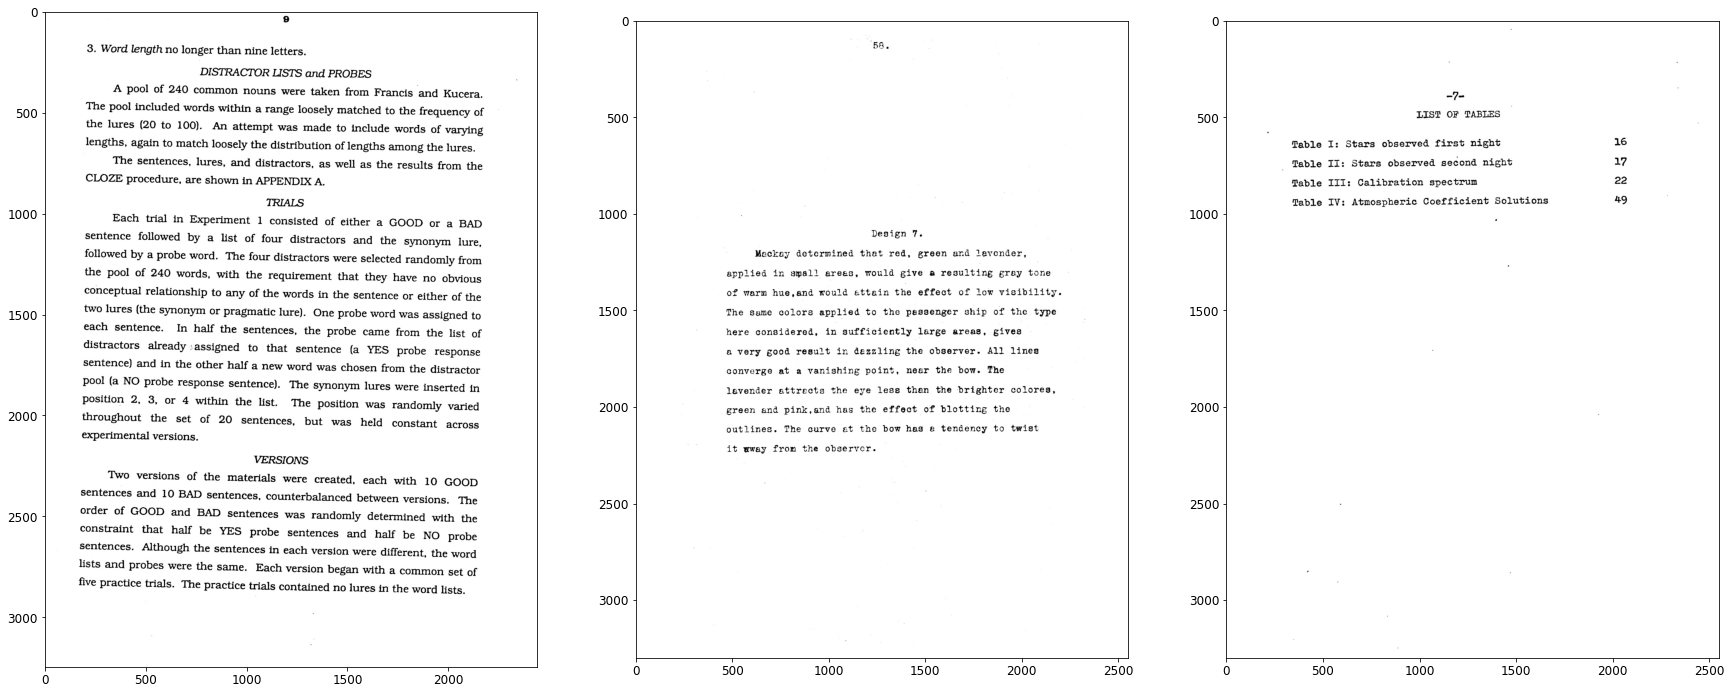

In [103]:
fig, ax = plt.subplots(1,nr,figsize=(30,20))

for i,ind in enumerate(inds):
    fn = fnames[ind].split('/')[-1].rstrip('.npz')
    img = np.array(Image.open(images_jpeg_dir+ fn+'.jpeg').convert('RGB'))

    # found in red
    for fb,cfb in zip(boxes_found[ind],labels_found[ind]):
        xmin1 = fb[0]/config.IMAGE_W*img.shape[1]
        xmax1 = fb[2]/config.IMAGE_W*img.shape[1]
        ymin1 = fb[1]/config.IMAGE_H*img.shape[0]
        ymax1 = fb[3]/config.IMAGE_H*img.shape[0]
        if LABELS[cfb] == 'figure':
            cv.rectangle(img, (round(xmin1), round(ymin1)), (round(xmax1),round(ymax1)), (255, 175, 0), 7)
        else:
            cv.rectangle(img, (round(xmin1), round(ymin1)), (round(xmax1),round(ymax1)), (255, 0, 0), 7)  

    for fb in boxes_true[ind]:
        xmin1 = fb[0]/config.IMAGE_W*img.shape[1]
        xmax1 = fb[2]/config.IMAGE_W*img.shape[1]
        ymin1 = fb[1]/config.IMAGE_H*img.shape[0]
        ymax1 = fb[3]/config.IMAGE_H*img.shape[0]
        cv.rectangle(img, (round(xmin1), round(ymin1)), (round(xmax1),round(ymax1)), (0, 0, 255), 5)  
        
    ax[i].imshow(img)

plt.show()

In [104]:
TPv, FPv, FNv, totalTruev = calc_base_metrics_allboxes_cv(LABELS,scoreminVec,iouminVec,
                                              boxes_true,boxes_found,labels_found, 
                                              scores_found,n_folds_cv=n_folds_cv,
                                                         seed=seed)
precision, precision_std, recall, \
  recall_std, f1, f1_std = calc_prec_rec_f1_cv(TPv,FPv,FNv,
                                               LABELS,scoreminVec,
                                               iouminVec)

/Users/jillnaiman/anaconda3/envs/Paper1/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.


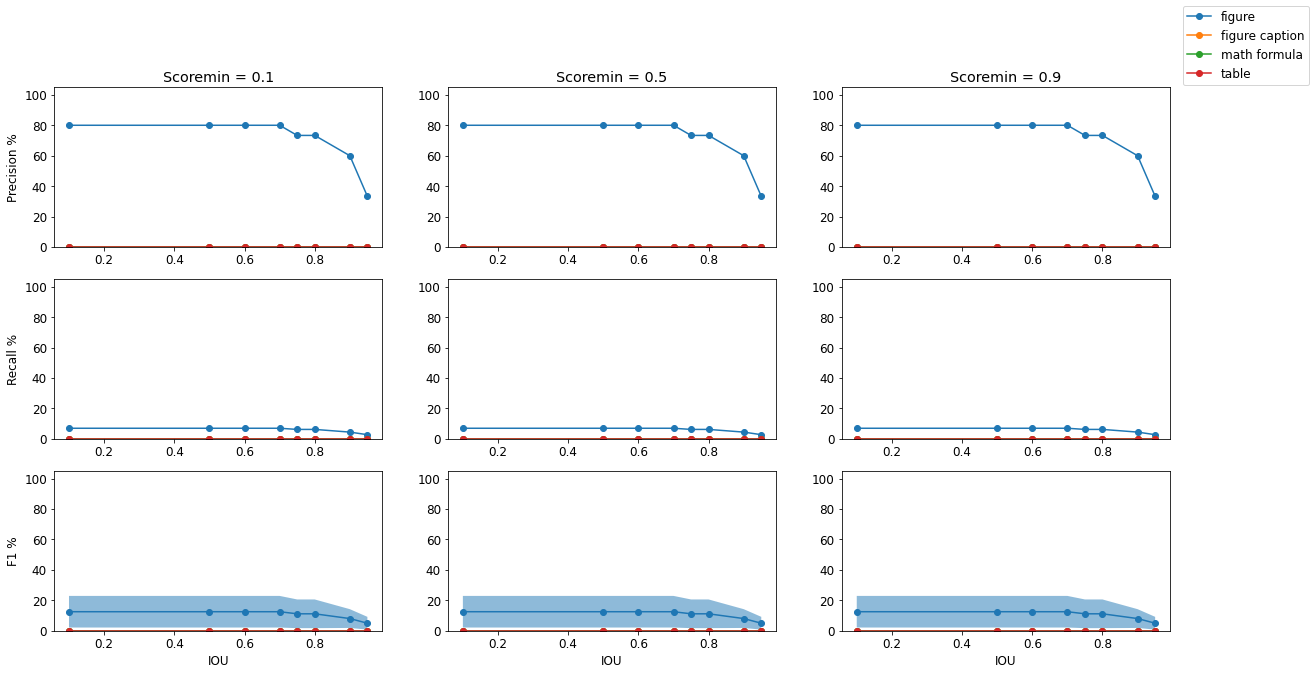

In [105]:
if len(scoreminVec) == 1:
    fig, ax = plt.subplots(3,len(scoreminVec),  figsize=(10,10))
    ax = np.array([ax,ax]).T
else:
    fig, ax = plt.subplots(3,len(scoreminVec),  figsize=(20,10))

ps = []
for i in range(len(scoreminVec)):
    for k in range(len(LABELS)): p1, = ax[0][i].plot(iouminVec,precision[k,i,:],'o-')
    ps.append(p1)
    ax[0][i].set_title('Scoremin = '+str(scoreminVec[i]))
    ax[0][0].set_ylabel('Precision %')
    ax[0][i].set_ylim(0,105)
    
    for k in range(len(LABELS)): ax[1][i].plot(iouminVec,recall[k,i,:], 'o-')
    ax[1][0].set_ylabel('Recall %')
    ax[1][i].set_ylim(0,105)
    
    for k in range(len(LABELS)): 
        ax[2][i].plot(iouminVec,f1[k,i,:], 'o-')
        # include stddev
        ax[2][i].fill_between(iouminVec, f1[k,i,:]-f1_std[k,i,:], f1[k,i,:]+f1_std[k,i,:], alpha=0.5)
    
    ax[2][0].set_ylabel('F1 %')
    ax[2][i].set_ylim(0,105)
        
    ax[-1][i].set_xlabel('IOU')

fig.legend(ps, labels=LABELS)
matplotlib.rcParams.update({'font.size': 12})
plt.show()

In [106]:
scoremin = 0.1

#Shape is: (# labels, #scores, #ious, #CV folds)
TPs, FPs, FNs, totalTrues = calc_base_metrics_allboxes_cv(LABELS,[scoremin],[0.8,0.8,0.8,0.8],
                                              boxes_true,boxes_found,labels_found, 
                                              scores_found,n_folds_cv=n_folds_cv,
                                                         seed=seed)
totalTrue = totalTrues.sum(axis=1).astype('int') # collapse onto 1 axis
TP = np.diagonal(TPs[:,0,:,:].sum(axis=2)) # sum across all CV, then for the right IOU
FP = np.diagonal(FPs[:,0,:,:].sum(axis=2)) # sum across all CV, then for the right IOU
FN = np.diagonal(FNs[:,0,:,:].sum(axis=2)) # sum across all CV, then for the right IOU

precisions, precision_stds, recalls, \
  recall_stds, f1s, f1_stds = calc_prec_rec_f1_cv(TPs,FPs,FNs,
                                               LABELS,[scoremin],
                                               [0.8,0.8,0.8,0.8])
precision = np.diagonal(precisions[:,0,:]) 
precision_std = np.diagonal(precision_stds[:,0,:]) 
recall = np.diagonal(recalls[:,0,:]) 
recall_std = np.diagonal(recall_stds[:,0,:]) 
f1 = np.diagonal(f1s[:,0,:]) 
f1_std = np.diagonal(f1_stds[:,0,:]) 

print_metrics_table(totalTrue,TP,FP,FN,
                        precision, precision_std, recall, recall_std,f1,f1_std,
                        LABELS, scoremin, n_folds_cv, [0.8,0.8,0.8,0.8])

SCORE =  0.1  N_CV =  5
Metric          figure          figure caption  math formula    table          
iou cut         0.8             0.8             0.8             0.8            
# of objs       140             94              0               0              
--------------------------------------------------------------------------------------------
TP              5.0%            0.0%            nan%            nan%           
FP              0.7%            1.1%            nan%            nan%           
FN              94.3%           98.9%           nan%            nan%           
--------------------------------------------------------------------------------------------
Precision       73.3+/-38.9%    0.0+/-0.0%      0.0+/-0.0%      0.0+/-0.0%     
Recall          6.3+/-5.5%      0.0+/-0.0%      0.0+/-0.0%      0.0+/-0.0%     
F1              11.2+/-9.4%     0.0+/-0.0%      0.0+/-0.0%      0.0+/-0.0%     


../metric_utils.py:689: RuntimeWarning: invalid value encountered in double_scalars
  out.append( str(round(TP[i]/totalTrue[i]*100,1))+'%' )
../metric_utils.py:695: RuntimeWarning: invalid value encountered in double_scalars
  out.append( str(round(FP[i]/totalTrue[i]*100,1))+'%' )
../metric_utils.py:701: RuntimeWarning: invalid value encountered in double_scalars
  out.append( str(round(FN[i]/totalTrue[i]*100,1))+'%' )


In [5]:
if use_valid: adder = '_valid'

How do we want to quantify how well we are doing?

In [6]:
n_folds_cv = 5 # for calculating the spread in our metrics, we we'll do a CV
scoreminVec = [0.1, 0.5, 0.9] # list of minimum box "scores"
iouminVec = [0.1, 0.5, 0.6, 0.7, 0.75, 0.8, 0.9, 0.95] # list of IOU cut offs we want to explore

# other classes
other_classes = ['text', 'title', 'list', 'table', 'figure']

In [7]:
import pickle
from sys import path
path.append('../')
import config
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
from PIL import Image
import cv2 as cv
from metric_utils import calc_base_metrics_allboxes_cv, calc_prec_rec_f1_cv, print_metrics_table, \
  get_years_dataframe

In [8]:
# # debugging
# import metric_utils
# reload(metric_utils)
# from metric_utils import calc_base_metrics_allboxes_cv,calc_metrics

In [9]:
# # build up filename
pp = config.metric_results_dir
pp += binary_dirs.split('/')[0]
pp += adder
pp += '.pickle'

with open(pp, 'rb') as ff:
    icombo,imgs_name, truebox, pdfboxes, pdfrawboxes, captionText_figcap,\
                 bbox_figcap_pars,\
                 sboxes_cleaned, slabels_cleaned, sscores_cleaned,\
                 boxes_pdf, labels_pdf, scores_pdf,\
                 boxes_heur, labels_heur, scores_heur,\
                 boxes_heur2, labels_heur2, scores_heur2,\
                 boxes_par_found, labels_par_found, scores_par_found,\
                 boxes_sq1, labels_sq1, scores_sq1,\
                 boxes_sq2, labels_sq2, scores_sq2,\
                 boxes_sq3, labels_sq3, scores_sq3,\
                 boxes_sq4, labels_sq4, scores_sq4,\
                 boxes_sq5, labels_sq5, scores_sq5,\
                 truebox1,truebox2,truebox3,rotatedImage,LABELS,boxes1, scores1, labels1 = pickle.load(ff)
    
with open(pp2, 'rb') as ff:
    img_names_fb,boxes_fb,classes_fb,scores_fb,height,width = pickle.load(ff)

In [10]:
LABELS

['figure', 'figure caption', 'math formula', 'table']

Combine into true/found combos:

In [11]:
# inames2 = []; bfb = []; cfb = []; scs = []; alltext = []
# for icount,(im,b,c,s,h,w) in enumerate(zip(img_names_fb,boxes_fb,classes_fb,scores_fb,height,width)):
#     xx = np.array(b) # found boxes
#     if len(xx) > 0:
#         xx = xx.reshape(xx.shape[0],xx.shape[2])
#     else:
#         xx = np.array([])
            
#     inames2.append(im.split('/')[-1].split('.jpeg')[0]) # save the name
#     cc = np.array(c).flatten() # found classes array
#     cc2 = []; # save classes for figure only
#     x22 = []; # save boxes for figure only
#     sc = []; # save scores for figure only
#     att = [] # save all text boxes for plotting later
#     for x,ccc,ss in zip(xx,cc,s): # loop and re-index
#         # save all coordinates in YOLO format
#         x1 = x[0]/w*config.IMAGE_W
#         y1 = x[1]/h*config.IMAGE_H
#         x2 = x[2]/w*config.IMAGE_W
#         y2 = x[3]/h*config.IMAGE_H
#         if other_classes[ccc] == 'figure':
#             cc2.append(LABELS.index('figure'))
#             x22.append(np.array([x1,y1,x2,y2]))
#             sc.append(ss[0])
#         if other_classes[ccc] == 'text':
#             att.append(np.array([x1,y1,x2,y2]))
            
            
#     # loop and find possible fig caption
#     caps = []; 
#     caps_box = []; 
#     cap_s = []
#     x23 = []
#     for figb in x22: # loop over only figure boxes
#         capd = 1e20; iind = -1
#         for ii,(x,ccc,ss) in enumerate(zip(xx,cc,s)): # loop over all boxes, classes, scores  
#             if other_classes[ccc] == 'text': # if this class is labeled as text
#                 # translate into YOLO format
#                 x1 = x[0]/w*config.IMAGE_W
#                 y1 = x[1]/h*config.IMAGE_H
#                 x2 = x[2]/w*config.IMAGE_W
#                 y2 = x[3]/h*config.IMAGE_H   
#                 xc = 0.5*(x1+x2); yc = 0.5*(y2+y1) # find center of caption
#                 xf = 0.5*(figb[0]+figb[2]); yf = (figb[1]+figb[3])*0.5
#                 d = np.sqrt( (xc-xf)**2 + (yc-yf)**2 )
#                 if d < capd:
#                     iind = ii
#                     capd = d
            
            
#     if icount == 649: import sys; sys.exit()

In [12]:
inames2 = []; bfb = []; cfb = []; scs = []; alltext = []
for im,b,c,s,h,w in zip(img_names_fb,boxes_fb,classes_fb,scores_fb,height,width):
    xx = np.array(b)
    if len(xx) > 0:
        xx = xx.reshape(xx.shape[0],xx.shape[2])
    else:
        xx = np.array([])
    inames2.append(im.split('/')[-1].split('.jpeg')[0])
    cc = np.array(c).flatten()
    cc2 = []; x22 = []; sc = []; att = []
    for x,ccc,ss in zip(xx,cc,s): # loop and re-index
        x1 = x[0]/w*config.IMAGE_W
        y1 = x[1]/h*config.IMAGE_H
        x2 = x[2]/w*config.IMAGE_W
        y2 = x[3]/h*config.IMAGE_H
        if other_classes[ccc] == 'figure':
            cc2.append(LABELS.index('figure'))
            x22.append(np.array([x1,y1,x2,y2]))
            sc.append(ss[0])
        if other_classes[ccc] == 'text':
            att.append(np.array([x1,y1,x2,y2]))
            
    # loop and find possible fig caption
    caps = []; caps_box = []; cap_s = []
    x23 = []
    for figb in x22:
        capd = 1e20; iind = -1
        for ii,(x,ccc,ss) in enumerate(zip(xx,cc,s)): # loop and re-index    
            if other_classes[ccc] == 'text':
                x1 = x[0]/w*config.IMAGE_W
                y1 = x[1]/h*config.IMAGE_H
                x2 = x[2]/w*config.IMAGE_W
                y2 = x[3]/h*config.IMAGE_H   
                xc = 0.5*(x1+x2); yc = 0.5*(y2+y1)
                #xf = 0.5*(figb[0]+figb[2]); yf = 0.5*(figb[1]+figb[3])
                # closest to center
                #xf = 0.5*(figb[0]+figb[2]); yf = figb[3]
                xf = 0.5*(figb[0]+figb[2]); yf = (figb[1]+figb[3])*0.5
                d = np.sqrt( (xc-xf)**2 + (yc-yf)**2 )
                if d < capd:
                    iind = ii
                    capd = d
                    
        xarr = np.array(xx[iind])
        x23.append(np.array([xarr[0]/w*config.IMAGE_W,xarr[1]/h*config.IMAGE_H, 
                             xarr[2]/w*config.IMAGE_W,xarr[3]/h*config.IMAGE_H]))
        sc.append(s[iind][0])
        cc2.append(LABELS.index('figure caption'))
                   
        #import sys; sys.exit()      
            
    #import sys; sys.exit()
    x22.extend(x23)
            
    bfb.append(x22)
    cfb.append(cc2)
    scs.append(sc)
    alltext.append(att)
        
df1 = pd.DataFrame({'name':inames2, 'found_fb':bfb, 'classes_fb':cfb, 'scores_fb':scs, 'alltext':alltext})

In [13]:
inames1 = []
for im in imgs_name:
    inames1.append(im.split('/')[-1].split('.npz')[0])
    
df2 = pd.DataFrame({'name':inames1, 'found':boxes_sq5, 'classes':labels_sq5, 'true':truebox1, 
                   'true_pp':truebox3})
# for true, use the less processed ones like truebox1 or truebox2 -- choose the best, probably the least processed which is truebox1

In [14]:
#dfall = df1.merge(df2, on='name', how='inner')
dfall = df1.set_index('name').join(df2.set_index('name'))

In [15]:
dfall

,found_fb,classes_fb,scores_fb,alltext,found,classes,true,true_pp
name,,,,,,,,
1995ApJ___448__634B_p11,"[[76.07917650531287, 45.058726325757576, 431.8...","[0, 0, 1, 1]","[0.99199015, 0.6366508, 0.98798496, 0.98798496]","[[42.836620056080285, 437.1360984848485, 484.0...","[[42.51554506099961, 438.3030303030303, 480.56...","[1, 0]","[[43.0, 438.0, 481.0, 460.0, 2.0], [80.0, 49.0...","[[43.0, 438.0, 481.0, 460.0, 2.0], [43.0, 49.0..."
1903ApJ____18__299R_p9,"[[111.44905637254902, 35.609554924242424, 411....","[0, 0, 0, 0, 1, 1, 1, 1]","[0.990144, 0.93186873, 0.82943887, 0.63344795,...","[[98.97450980392156, 388.1955681818182, 408.98...","[[99.58901960784314, 388.96484848484846, 332.9...","[1, 0, 2]","[[100.0, 389.0, 407.0, 395.0, 2.0], [127.0, 26...","[[100.0, 389.0, 407.0, 395.0, 2.0], [100.0, 26..."
1995ApJ___445L__23E_p0,[],[],[],"[[30.6653431372549, 241.30701720986903, 239.50...",[],[],[],[]
1916ApJ____44__190H_p7,[],[],[],"[[81.77708946078431, 57.0464678030303, 370.913...",[],[],[],[]
1993AJ____106____1S_p1,[],[],[],"[[260.0475245098039, 303.28170454545455, 448.6...","[[100.21757507324219, 38.84473419189453, 402.9...",[3],"[[113.0, 46.0, 394.0, 177.0, 4.0]]","[[113.0, 46.0, 394.0, 177.0, 4.0]]"
...,...,...,...,...,...,...,...,...
1994ApJ___430__467V_p2,[],[],[],"[[38.4915931372549, 212.10514392324095, 45.899...","[[31.224884033203125, 46.54243469238281, 492.9...",[0],"[[25.0, 46.0, 475.0, 473.0, 4.0]]","[[25.0, 46.0, 475.0, 473.0, 4.0]]"
1980ApJ___238__685G_p14,"[[58.29986519607843, 38.66971590909091, 459.43...","[0, 1]","[0.9974953, 0.99403507]","[[59.099724264705884, 415.65962121212124, 458....","[[59.83372549019608, 416.7369696969697, 456.38...","[1, 0]","[[60.0, 417.0, 456.0, 427.0, 2.0], [62.0, 45.0...","[[60.0, 417.0, 456.0, 427.0, 2.0], [60.0, 45.0..."
1995ApJ___453__100E_p10,"[[43.21281299193231, 62.85269886363636, 457.51...","[0, 1]","[0.9932708, 0.70065665]",[],"[[241.99606454151908, 444.3539393939394, 262.3...","[1, 0]","[[242.0, 444.0, 262.0, 448.0, 2.0], [59.0, 63....","[[242.0, 444.0, 262.0, 448.0, 2.0], [59.0, 63...."


## With our post-processing

In [16]:
from annotation_utils import get_all_ocr_files, collect_ocr_process_results, \
   get_makesense_info_and_years, get_years
from post_processing_utils import parse_annotations_to_labels, \
   get_true_boxes, get_ocr_results, get_image_process_boxes, clean_overlapping_squares, \
   clean_merge_pdfsquares, clean_merge_heurstic_captions, add_heuristic_captions, \
   clean_found_overlap_with_ocr, clean_true_overlap_with_ocr, clean_merge_squares, \
   clean_big_captions, clean_match_fig_cap, expand_true_boxes_fig_cap, \
   expand_found_boxes_fig_cap, expand_true_area_above_cap, expand_found_area_above_cap

/Users/jillnaiman/anaconda3/envs/Paper1/lib/python3.7/site-packages/yt/utilities/logger.py:4: VisibleDeprecationWarning: The configuration file /Users/jillnaiman/.config/yt/ytrc is deprecated in favor of /Users/jillnaiman/.config/yt/yt.toml. Currently, both are present. Please manually remove the deprecated one to silence this warning.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  from yt.config import ytcfg


In [17]:
#dfall.columns

In [18]:
#dfall.index

In [19]:
if save_binary_dir is None: save_binary_dir = config.save_binary_dir
if ocr_results_dir is None: ocr_results_dir = config.ocr_results_dir
if make_sense_dir is None: make_sense_dir = config.make_sense_dir
if images_jpeg_dir is None: images_jpeg_dir = config.images_jpeg_dir
# from config file
annotation_dir = save_binary_dir + config.ann_name + str(config.IMAGE_H) + 'x' + str(config.IMAGE_W) + '_ann/'


In [20]:
# let's get all of the ocr files
ocrFiles = get_all_ocr_files(ocr_results_dir=ocr_results_dir)
# get important quantities from these files
print('retreiving OCR data, this can take a moment...')
ws, paragraphs, squares, html, rotations,colorbars = collect_ocr_process_results(ocrFiles)
# create dataframe
dfh = pd.DataFrame({'ws':ws, 'paragraphs':paragraphs, 'squares':squares, 
                   'hocr':html, 'rotation':rotations, 'colorbars':colorbars})#, 'pdfwords':pdfwords})
dfh = dfh.drop_duplicates(subset='ws')
dfh = dfh.set_index('ws')

retreiving OCR data, this can take a moment...
##### OCR retrieval FILE: on 1 of 2  ##### 
--- OCR retrieval: on 0 of 5515 ---
--- OCR retrieval: on 1000 of 5515 ---
--- OCR retrieval: on 2000 of 5515 ---
--- OCR retrieval: on 3000 of 5515 ---
--- OCR retrieval: on 4000 of 5515 ---
--- OCR retrieval: on 5000 of 5515 ---
##### OCR retrieval FILE: on 2 of 2  ##### 
--- OCR retrieval: on 0 of 1500 ---
--- OCR retrieval: on 1000 of 1500 ---


In [21]:
dfMakeSense = get_makesense_info_and_years(dfh,make_sense_dir=make_sense_dir)

unique = 830 pages


In [22]:
feature_dir = save_binary_dir + binary_dirs
# feature_dir

In [23]:
# #dfMakeSense
# images_jpeg_dir
# config.bad_skews_file

In [47]:
#Index(['found_fb', 'classes_fb', 'scores_fb', 'alltext', 'found', 'classes','true'],
useColorbars = True

boxes_pp = []; labels_pp = []; scores_pp = []
boxes_pp2 = []; labels_pp2 = []; scores_pp2 = []
for i in range(len(dfall)):
    if i%200 == 0: print('on i=',i,'of',len(dfall))
    dfhere = dfall.iloc[i]
    imgs_name = dfhere.name
    a = annotation_dir+imgs_name+'.xml'
    boxes1 = dfhere['found_fb']
    scores1 = dfhere['scores_fb']
    labels1 = dfhere['classes_fb']

    # get OCR results and parse them, open image for image processing
    imgs_name_in = '/'+imgs_name+'.npz'
    dfMS = dfMakeSense.loc[dfMakeSense['filename']==imgs_name]

    backtorgb,image_np,rotatedImage,rotatedAngleOCR,bbox_hocr,\
      bboxes_words,bbsq,cbsq, rotation,bbox_par = get_ocr_results([imgs_name_in], 
                                                                  dfMakeSense,dfh,
                                                                 image_np=np.zeros([512,512]),
                                                                      images_jpeg_dir=images_jpeg_dir)

    sboxes_cleaned, slabels_cleaned, sscores_cleaned = clean_overlapping_squares(boxes1,
                                                                                 scores1,
                                                                                 labels1,
                                                                                 imgs_name_in)   

    # assume no PDF
    #pdfboxes = []; pdfrawboxes = []
    _, pdfboxes, pdfrawboxes,years_ind, _ = get_true_boxes(a,LABELS,
                                                       [],[],
                                                       annotation_dir=annotation_dir,
                                                      feature_dir=feature_dir,
                                                        check_for_file=False)
    
    boxes_pdf, labels_pdf, scores_pdf = clean_merge_pdfsquares(pdfboxes,
                                                           pdfrawboxes,
                                                           sboxes_cleaned, 
                                                           slabels_cleaned, 
                                                           sscores_cleaned, 
                                                           LABELS, dfMS)

    # assume no heuristics
    #bbox_figcap_pars = []
    # get figures and captions from image processing
    captionText_figcap, bbox_figcap_pars = get_image_process_boxes(backtorgb, 
                                                                       bbox_hocr, 
                                                                       rotatedImage)

    boxes_heur, labels_heur, scores_heur,\
      ibbOverlap, boxes_heur_tf  = clean_merge_heurstic_captions(boxes_pdf, 
                                            labels_pdf, scores_pdf, 
                                            bbox_figcap_pars, LABELS,dfMS)

    boxes_par_found, labels_par_found, \
      scores_par_found = clean_found_overlap_with_ocr(boxes_heur, labels_heur, 
                                                scores_heur,bboxes_words,
                                                      bbox_par,rotation,
                                                      LABELS, dfMS, boxes_heur_tf)   
    
    # if figure boxes are smaller than image-processing found boxes, merge them; 
    # also, do with colorbars as well if requested
    boxes_sq1, labels_sq1, scores_sq1, bbsq = clean_merge_squares(bbsq, cbsq,
                                                            boxes_par_found, 
                                                            labels_par_found, 
                                                            scores_par_found, 
                                                            LABELS, dfMS, 
                                                           useColorbars = useColorbars)
    
    # if there are any huge captions -- like 75% of the area of the page or more
    #. these are wrong, so drop them
    boxes_sq2, labels_sq2, scores_sq2 = clean_big_captions(boxes_sq1,
                                                        labels_sq1,
                                                        scores_sq1, 
                                                        LABELS)

    # sometimes captions are slightly overlapping with figures -- split the 
    # difference between those where they touch on the "bottom"
    # Default to captions found with mega yolo, if there is a figure but 
    #. no caption found, then see if there is a heuristically found caption
    boxes_sq3, labels_sq3, scores_sq3 = clean_match_fig_cap(boxes_sq2,
                                                             labels_sq2,
                                                         scores_sq2, bbsq,
                                                         LABELS, 
                                                         rotatedImage, 
                                                         rotatedAngleOCR,
                                                         dfMS)

    # again for found boxes?  I feel like maybe not the one above?
    boxes_sq4, labels_sq4, scores_sq4 = expand_found_boxes_fig_cap(boxes_sq3, 
                                                                labels_sq3, 
                                                                scores_sq3,
                                                                   bbsq,
                                                                rotatedImage, 
                                                                LABELS, dfMS)

    # same for found
    boxes_sq5, labels_sq5, scores_sq5 = expand_found_area_above_cap(boxes_sq4, 
                                                                    labels_sq4, 
                                                                    scores_sq4, 
                                                                    bbsq,
                                                                    rotatedImage, 
                                                                    LABELS, dfMS)
    
    # compare these to truebox1
    boxes_pp2.append(boxes_par_found)
    labels_pp2.append(labels_par_found)
    scores_pp2.append(scores_par_found)
    
    # compare these to truebox3
    boxes_pp.append(boxes_sq5)
    labels_pp.append(labels_sq5)
    scores_pp.append(scores_sq5)

# save these as well
dfall['found_fb_pp'] = boxes_pp
dfall['classes_fb_pp'] = labels_pp
dfall['scores_fb_pp'] = scores_pp

dfall['found_fb_pp2'] = boxes_pp2
dfall['classes_fb_pp2'] = labels_pp2
dfall['scores_fb_pp2'] = scores_pp2


on i= 0 of 830
something bad has happened with image_to_osd on 1987ApJ___319__671S_p6.jpeg
1987ApJ___319__671S_p6.jpeg something has happened with rotation -- page says angle = -1 words say angle = 0.0
1965AJ_____70__212B_p54.jpeg something has happened with rotation -- page says angle = 180 words say angle = 0.0
1961ApJ___133__723C_p1.jpeg something has happened with rotation -- page says angle = 180 words say angle = 0.0
1952ApJ___116__122R_p20.jpeg something has happened with rotation -- page says angle = 180 words say angle = 0.0
1990AJ____100_1369S_p6.jpeg something has happened with rotation -- page says angle = 180 words say angle = 0.0
on i= 200 of 830
1994ApJ___435L__43G_p2.jpeg something has happened with rotation -- page says angle = 180 words say angle = 0.0
something bad has happened with image_to_osd on 1987ApJS___63__265W_p12.jpeg
1987ApJS___63__265W_p12.jpeg something has happened with rotation -- page says angle = -1 words say angle = 0.0
1981AJ_____86_1044H_p2.jpeg so

In [48]:
    # backtorgb,image_np,rotatedImage,rotatedAngleOCR,bbox_hocr,\
    #   bboxes_words,bbsq,cbsq, rotation,bbox_par = get_ocr_results([imgs_name_in], 
    #                                                               dfMakeSense,df,
    #                                                              image_np=np.zeros([512,512]),
    #                                                                   images_jpeg_dir=images_jpeg_dir)


In [49]:
# dfall['found_fb_pp2'] = boxes_pp2
# dfall['classes_fb_pp2'] = labels_pp2
# dfall['scores_fb_pp2'] = scores_pp2


Show a random example:

In [50]:
nr = 3
inds = np.random.randint(0,len(dfall), nr)
inds
#inds = np.array([653, 649, 509]) # good test

array([402, 122, 670])

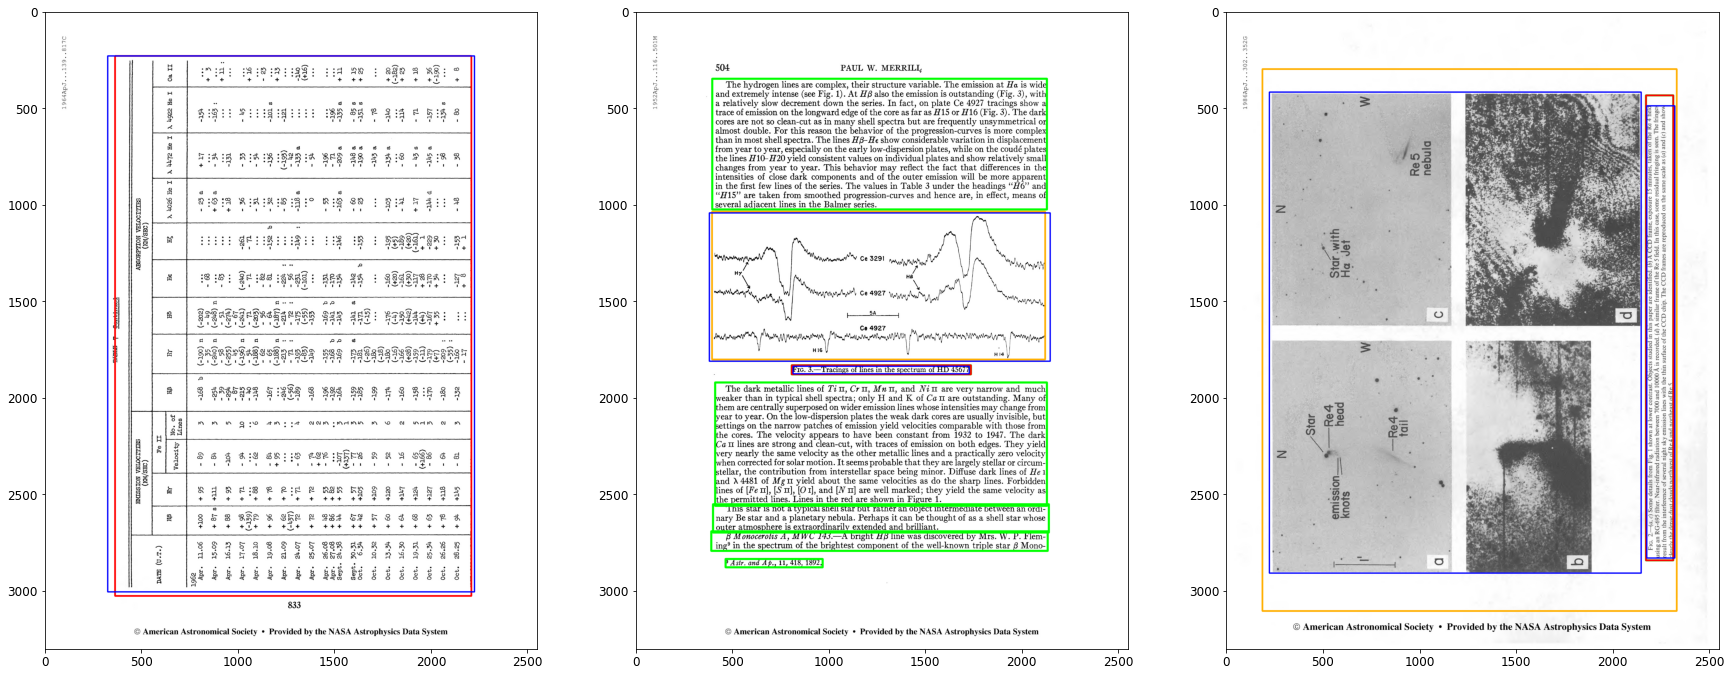

In [51]:
fig, ax = plt.subplots(1,nr,figsize=(30,20))

for i,ind in enumerate(inds):
    img = np.array(Image.open(images_jpeg_dir+ dfall.iloc[ind].name+'.jpeg').convert('RGB'))

    #overplot squares

    # green show all text boxes
    for fb in dfall.iloc[ind]['alltext']:
        xmin1 = fb[0]/config.IMAGE_W*img.shape[1]
        xmax1 = fb[2]/config.IMAGE_W*img.shape[1]
        ymin1 = fb[1]/config.IMAGE_H*img.shape[0]
        ymax1 = fb[3]/config.IMAGE_H*img.shape[0]
        cv.rectangle(img, (round(xmin1), round(ymin1)), (round(xmax1),round(ymax1)), (0, 255, 0), 10)  

    # found in red
    for fb,cfb in zip(dfall.iloc[ind]['found_fb'],dfall.iloc[ind]['classes_fb']):
        xmin1 = fb[0]/config.IMAGE_W*img.shape[1]
        xmax1 = fb[2]/config.IMAGE_W*img.shape[1]
        ymin1 = fb[1]/config.IMAGE_H*img.shape[0]
        ymax1 = fb[3]/config.IMAGE_H*img.shape[0]
        if LABELS[cfb] == 'figure':
            cv.rectangle(img, (round(xmin1), round(ymin1)), (round(xmax1),round(ymax1)), (255, 175, 0), 7)
        else:
            cv.rectangle(img, (round(xmin1), round(ymin1)), (round(xmax1),round(ymax1)), (255, 0, 0), 7)  

    # for fb in dfall.iloc[ind]['found']:
    #     xmin1 = fb[0]/config.IMAGE_W*img.shape[1]
    #     xmax1 = fb[2]/config.IMAGE_W*img.shape[1]
    #     ymin1 = fb[1]/config.IMAGE_H*img.shape[0]
    #     ymax1 = fb[3]/config.IMAGE_H*img.shape[0]
    #     cv.rectangle(img, (round(xmin1), round(ymin1)), (round(xmax1),round(ymax1)), (255, 0, 255), 5)  

    for fb in dfall.iloc[ind]['true']:
        xmin1 = fb[0]/config.IMAGE_W*img.shape[1]
        xmax1 = fb[2]/config.IMAGE_W*img.shape[1]
        ymin1 = fb[1]/config.IMAGE_H*img.shape[0]
        ymax1 = fb[3]/config.IMAGE_H*img.shape[0]
        cv.rectangle(img, (round(xmin1), round(ymin1)), (round(xmax1),round(ymax1)), (0, 0, 255), 5)  
        


    ax[i].imshow(img)

plt.show()

In [52]:
#dfall.iloc[0]['found_fb']

In [71]:
trueshere = np.array(dfall['true'].values).tolist(); boxes_fb = dfall['found_fb'].values.tolist(); 
labels_fb = dfall['classes_fb'].values.tolist(); scores_fb = dfall['scores_fb'].values.tolist()

boxes_fb_pp = dfall['found_fb_pp'].values.tolist(); 
labels_fb_pp = dfall['classes_fb_pp'].values.tolist(); scores_fb_pp = dfall['scores_fb_pp'].values.tolist()

# boxes_fb_pp = dfall['found_fb_pp2'].values.tolist(); 
# labels_fb_pp = dfall['classes_fb_pp2'].values.tolist(); scores_fb_pp = dfall['scores_fb_pp2'].values.tolist()
# trueshere_pp = np.array(dfall['true_pp'].values).tolist()

In [72]:
#scores_fb[:3]

In [73]:
#scores_sq5[:3]

In [74]:
TPv, FPv, FNv, totalTruev = calc_base_metrics_allboxes_cv(LABELS,scoreminVec,iouminVec,
                                              trueshere,boxes_fb,labels_fb, 
                                              scores_fb,n_folds_cv=n_folds_cv,
                                                         seed=seed)

In [75]:
#config.metric_results_dir

Final box analytics:

In [76]:
# TPv, FPv, FNv, totalTruev = calc_base_metrics_allboxes_cv(LABELS,scoreminVec,iouminVec,
#                                               truebox3,boxes_sq5,labels_sq5, 
#                                               scores_sq5,n_folds_cv=n_folds_cv)

In [77]:
TPv.shape

(4, 3, 8, 5)

Shape is: (# labels, #scores, #ious, #CV folds)

Calculate precision, recall, F1 (ignore /0 warnings, taken care of):

In [78]:
precision, precision_std, recall, \
  recall_std, f1, f1_std = calc_prec_rec_f1_cv(TPv,FPv,FNv,
                                               LABELS,scoreminVec,
                                               iouminVec)

Plot and check it out!

/Users/jillnaiman/anaconda3/envs/Paper1/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.


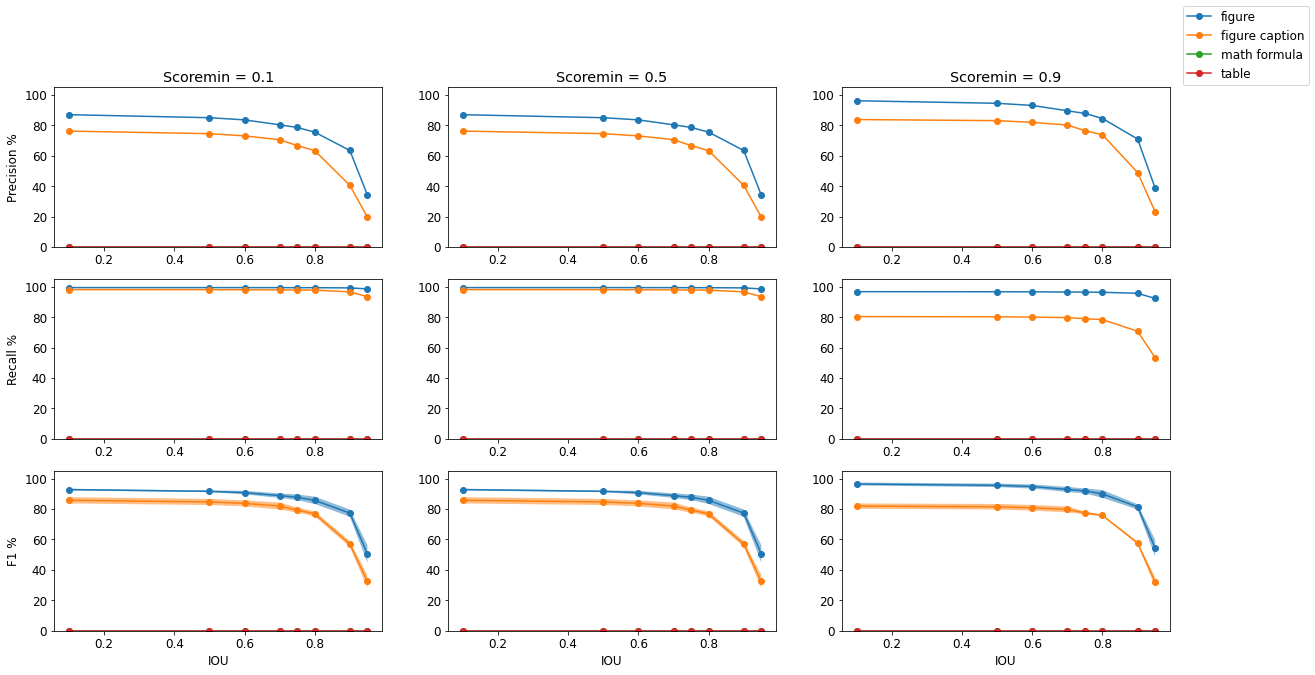

In [79]:
if len(scoreminVec) == 1:
    fig, ax = plt.subplots(3,len(scoreminVec),  figsize=(10,10))
    ax = np.array([ax,ax]).T
else:
    fig, ax = plt.subplots(3,len(scoreminVec),  figsize=(20,10))

ps = []
for i in range(len(scoreminVec)):
    for k in range(len(LABELS)): p1, = ax[0][i].plot(iouminVec,precision[k,i,:],'o-')
    ps.append(p1)
    ax[0][i].set_title('Scoremin = '+str(scoreminVec[i]))
    ax[0][0].set_ylabel('Precision %')
    ax[0][i].set_ylim(0,105)
    
    for k in range(len(LABELS)): ax[1][i].plot(iouminVec,recall[k,i,:], 'o-')
    ax[1][0].set_ylabel('Recall %')
    ax[1][i].set_ylim(0,105)
    
    for k in range(len(LABELS)): 
        ax[2][i].plot(iouminVec,f1[k,i,:], 'o-')
        # include stddev
        ax[2][i].fill_between(iouminVec, f1[k,i,:]-f1_std[k,i,:], f1[k,i,:]+f1_std[k,i,:], alpha=0.5)
    
    ax[2][0].set_ylabel('F1 %')
    ax[2][i].set_ylim(0,105)
        
    ax[-1][i].set_xlabel('IOU')

fig.legend(ps, labels=LABELS)
matplotlib.rcParams.update({'font.size': 12})
plt.show()

For post-processed boxes:

/Users/jillnaiman/anaconda3/envs/Paper1/lib/python3.7/site-packages/ipykernel_launcher.py:38: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.


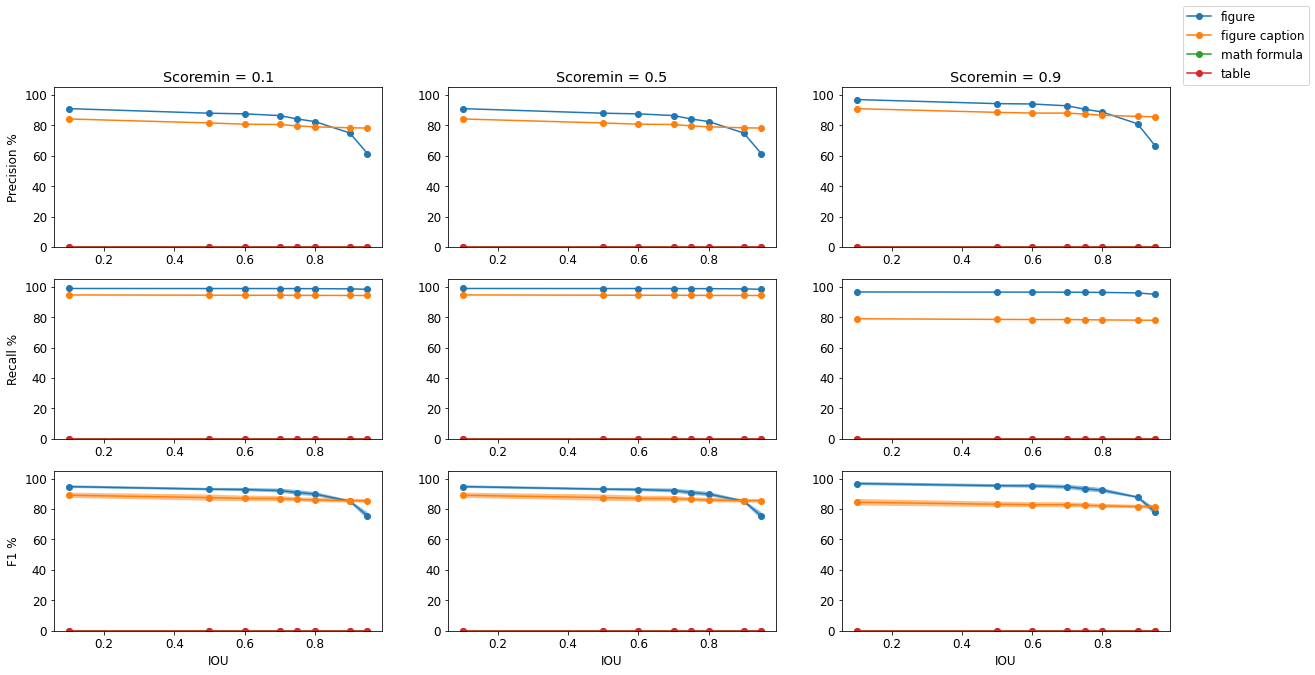

In [80]:
TPv, FPv, FNv, totalTruev = calc_base_metrics_allboxes_cv(LABELS,scoreminVec,iouminVec,
                                              trueshere_pp,boxes_fb_pp,labels_fb_pp, 
                                              scores_fb_pp,n_folds_cv=n_folds_cv,
                                                         seed=seed)
precision, precision_std, recall, \
  recall_std, f1, f1_std = calc_prec_rec_f1_cv(TPv,FPv,FNv,
                                               LABELS,scoreminVec,
                                               iouminVec)

if len(scoreminVec) == 1:
    fig, ax = plt.subplots(3,len(scoreminVec),  figsize=(10,10))
    ax = np.array([ax,ax]).T
else:
    fig, ax = plt.subplots(3,len(scoreminVec),  figsize=(20,10))

ps = []
for i in range(len(scoreminVec)):
    for k in range(len(LABELS)): p1, = ax[0][i].plot(iouminVec,precision[k,i,:],'o-')
    ps.append(p1)
    ax[0][i].set_title('Scoremin = '+str(scoreminVec[i]))
    ax[0][0].set_ylabel('Precision %')
    ax[0][i].set_ylim(0,105)
    
    for k in range(len(LABELS)): ax[1][i].plot(iouminVec,recall[k,i,:], 'o-')
    ax[1][0].set_ylabel('Recall %')
    ax[1][i].set_ylim(0,105)
    
    for k in range(len(LABELS)): 
        ax[2][i].plot(iouminVec,f1[k,i,:], 'o-')
        # include stddev
        ax[2][i].fill_between(iouminVec, f1[k,i,:]-f1_std[k,i,:], f1[k,i,:]+f1_std[k,i,:], alpha=0.5)
    
    ax[2][0].set_ylabel('F1 %')
    ax[2][i].set_ylim(0,105)
        
    ax[-1][i].set_xlabel('IOU')

fig.legend(ps, labels=LABELS)
matplotlib.rcParams.update({'font.size': 12})
plt.show()

Choose a score cut-off.  For the most part, we've found 0.1 to be fine:

In [81]:
scoremin = 0.1 #95

What IOU cut-offs for each label? for reference:

In [82]:
LABELS

['figure', 'figure caption', 'math formula', 'table']

In [83]:
ioumin_per_label = [0.9, 0.95, 0.8, 0.6] # fig, fig+caption, math formula, table

In [84]:
#Shape is: (# labels, #scores, #ious, #CV folds)
# TPs, FPs, FNs, totalTrues = calc_base_metrics_allboxes_cv(LABELS,[scoremin],ioumin_per_label,
#                                               truebox3,boxes_sq5,labels_sq5, 
#                                               scores_sq5,n_folds_cv=n_folds_cv)
TPs, FPs, FNs, totalTrues = calc_base_metrics_allboxes_cv(LABELS,[scoremin],ioumin_per_label,
                                              trueshere,boxes_fb,labels_fb, 
                                              scores_fb,n_folds_cv=n_folds_cv,
                                                         seed=seed)
totalTrue = totalTrues.sum(axis=1).astype('int') # collapse onto 1 axis
TP = np.diagonal(TPs[:,0,:,:].sum(axis=2)) # sum across all CV, then for the right IOU
FP = np.diagonal(FPs[:,0,:,:].sum(axis=2)) # sum across all CV, then for the right IOU
FN = np.diagonal(FNs[:,0,:,:].sum(axis=2)) # sum across all CV, then for the right IOU

In [85]:
precisions, precision_stds, recalls, \
  recall_stds, f1s, f1_stds = calc_prec_rec_f1_cv(TPs,FPs,FNs,
                                               LABELS,[scoremin],
                                               ioumin_per_label)
precision = np.diagonal(precisions[:,0,:]) 
precision_std = np.diagonal(precision_stds[:,0,:]) 
recall = np.diagonal(recalls[:,0,:]) 
recall_std = np.diagonal(recall_stds[:,0,:]) 
f1 = np.diagonal(f1s[:,0,:]) 
f1_std = np.diagonal(f1_stds[:,0,:]) 

In [86]:
print_metrics_table(totalTrue,TP,FP,FN,
                        precision, precision_std, recall, recall_std,f1,f1_std,
                        LABELS, scoremin, n_folds_cv, ioumin_per_label)

SCORE =  0.1  N_CV =  5
Metric          figure          figure caption  math formula    table          
iou cut         0.9             0.95            0.8             0.6            
# of objs       490             493             318             218            
--------------------------------------------------------------------------------------------
TP              72.0%           22.3%           0.0%            0.0%           
FP              41.8%           90.9%           0.0%            0.0%           
FN              0.6%            1.6%            100.0%          100.0%         
--------------------------------------------------------------------------------------------
Precision       63.4+/-3.6%     19.7+/-3.2%     0.0+/-0.0%      0.0+/-0.0%     
Recall          99.2+/-1.1%     93.4+/-5.6%     0.0+/-0.0%      0.0+/-0.0%     
F1              77.3+/-2.4%     32.4+/-4.2%     0.0+/-0.0%      0.0+/-0.0%     


In [87]:
#Shape is: (# labels, #scores, #ious, #CV folds)
TPs, FPs, FNs, totalTrues = calc_base_metrics_allboxes_cv(LABELS,[scoremin],[0.8,0.8,0.8,0.8],
                                              trueshere,boxes_fb,labels_fb, 
                                              scores_fb,n_folds_cv=n_folds_cv,
                                                         seed=seed)
totalTrue = totalTrues.sum(axis=1).astype('int') # collapse onto 1 axis
TP = np.diagonal(TPs[:,0,:,:].sum(axis=2)) # sum across all CV, then for the right IOU
FP = np.diagonal(FPs[:,0,:,:].sum(axis=2)) # sum across all CV, then for the right IOU
FN = np.diagonal(FNs[:,0,:,:].sum(axis=2)) # sum across all CV, then for the right IOU

precisions, precision_stds, recalls, \
  recall_stds, f1s, f1_stds = calc_prec_rec_f1_cv(TPs,FPs,FNs,
                                               LABELS,[scoremin],
                                               [0.8,0.8,0.8,0.8])
precision = np.diagonal(precisions[:,0,:]) 
precision_std = np.diagonal(precision_stds[:,0,:]) 
recall = np.diagonal(recalls[:,0,:]) 
recall_std = np.diagonal(recall_stds[:,0,:]) 
f1 = np.diagonal(f1s[:,0,:]) 
f1_std = np.diagonal(f1_stds[:,0,:]) 

print_metrics_table(totalTrue,TP,FP,FN,
                        precision, precision_std, recall, recall_std,f1,f1_std,
                        LABELS, scoremin, n_folds_cv, [0.8,0.8,0.8,0.8])

SCORE =  0.1  N_CV =  5
Metric          figure          figure caption  math formula    table          
iou cut         0.8             0.8             0.8             0.8            
# of objs       490             493             318             218            
--------------------------------------------------------------------------------------------
TP              85.9%           71.6%           0.0%            0.0%           
FP              28.0%           41.6%           0.0%            0.0%           
FN              0.6%            1.6%            100.0%          100.0%         
--------------------------------------------------------------------------------------------
Precision       75.5+/-4.3%     63.3+/-2.3%     0.0+/-0.0%      0.0+/-0.0%     
Recall          99.3+/-0.9%     97.7+/-2.1%     0.0+/-0.0%      0.0+/-0.0%     
F1              85.7+/-2.4%     76.8+/-1.7%     0.0+/-0.0%      0.0+/-0.0%     


For post-processed:

In [88]:
#Shape is: (# labels, #scores, #ious, #CV folds)
TPs, FPs, FNs, totalTrues = calc_base_metrics_allboxes_cv(LABELS,[scoremin],[0.8,0.8,0.8,0.8],
                                              trueshere_pp,boxes_fb_pp,labels_fb_pp, 
                                              scores_fb_pp,n_folds_cv=n_folds_cv,
                                                         seed=seed)
totalTrue = totalTrues.sum(axis=1).astype('int') # collapse onto 1 axis
TP = np.diagonal(TPs[:,0,:,:].sum(axis=2)) # sum across all CV, then for the right IOU
FP = np.diagonal(FPs[:,0,:,:].sum(axis=2)) # sum across all CV, then for the right IOU
FN = np.diagonal(FNs[:,0,:,:].sum(axis=2)) # sum across all CV, then for the right IOU

precisions, precision_stds, recalls, \
  recall_stds, f1s, f1_stds = calc_prec_rec_f1_cv(TPs,FPs,FNs,
                                               LABELS,[scoremin],
                                               [0.8,0.8,0.8,0.8])
precision = np.diagonal(precisions[:,0,:]) 
precision_std = np.diagonal(precision_stds[:,0,:]) 
recall = np.diagonal(recalls[:,0,:]) 
recall_std = np.diagonal(recall_stds[:,0,:]) 
f1 = np.diagonal(f1s[:,0,:]) 
f1_std = np.diagonal(f1_stds[:,0,:]) 

print_metrics_table(totalTrue,TP,FP,FN,
                        precision, precision_std, recall, recall_std,f1,f1_std,
                        LABELS, scoremin, n_folds_cv, [0.8,0.8,0.8,0.8])

SCORE =  0.1  N_CV =  5
Metric          figure          figure caption  math formula    table          
iou cut         0.8             0.8             0.8             0.8            
# of objs       490             487             318             218            
--------------------------------------------------------------------------------------------
TP              89.2%           81.5%           0.0%            0.0%           
FP              19.0%           21.8%           0.0%            0.0%           
FN              1.2%            4.9%            100.0%          100.0%         
--------------------------------------------------------------------------------------------
Precision       82.4+/-2.3%     79.0+/-1.8%     0.0+/-0.0%      0.0+/-0.0%     
Recall          98.7+/-1.3%     94.3+/-2.8%     0.0+/-0.0%      0.0+/-0.0%     
F1              89.8+/-1.3%     85.9+/-1.5%     0.0+/-0.0%      0.0+/-0.0%     


## Vs. Time
Also, let's plot metrics vs. year.

In [49]:
# pick a min score and a min IOU
scoremin = 0.95
ioumin = 0.8

In [50]:
try:
    df = get_years_dataframe(imgs_name,scoremin,ioumin,LABELS,
                       truebox3,boxes_sq5,labels_sq5,scores_sq5)
except:
    print('years are faked...')
    df = get_years_dataframe(imgs_name,scoremin,ioumin,LABELS,
                       truebox3,boxes_sq5,labels_sq5,scores_sq5, 
                            fake_years=True)

years are faked...


In [51]:
df.head()

,years,total:figure,total:figure caption,total:math formula,total:table,TP:figure,TP:figure caption,TP:math formula,TP:table,FP:figure,FP:figure caption,FP:math formula,FP:table,FN:figure,FN:figure caption,FN:math formula,FN:table
0,1903-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1908-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1910-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1918-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1922-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [52]:
sampleHist = '10Y' # 5 years

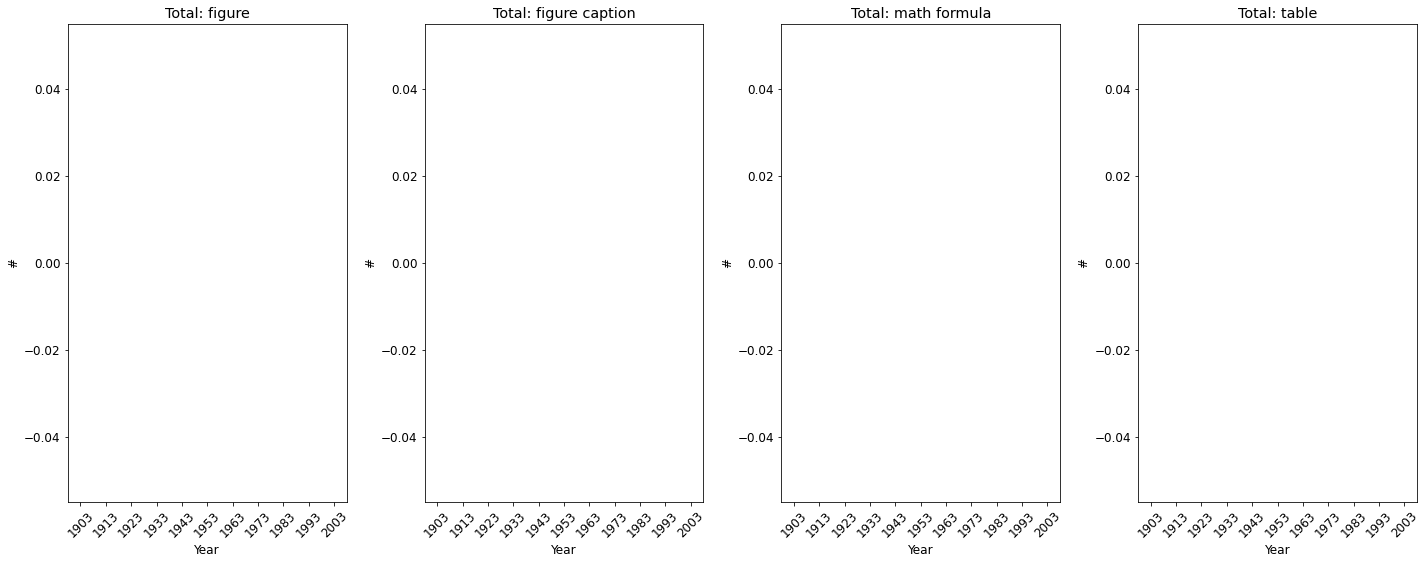

In [53]:
# loop and plot
fig, ax = plt.subplots(1,len(LABELS), figsize=(20,8))
matplotlib.rcParams.update({'font.size': 12})

for il,l in enumerate(LABELS):
    quant = pd.Series(index=df['years'],data=np.array(df['total:'+l])).resample(sampleHist).sum()
    
    quant.plot(kind='bar',ax=ax[il])
    ax[il].set_xticklabels([x.strftime("%Y") for x in quant.index], rotation=45)
    ax[il].set_title('Total: ' + l)
    ax[il].set_ylabel('#')
    ax[il].set_xlabel('Year')
#plt.show()

plt.tight_layout()
#plt.savefig(saveFigDir+'yolo_noOCR_articles_per_year.png')

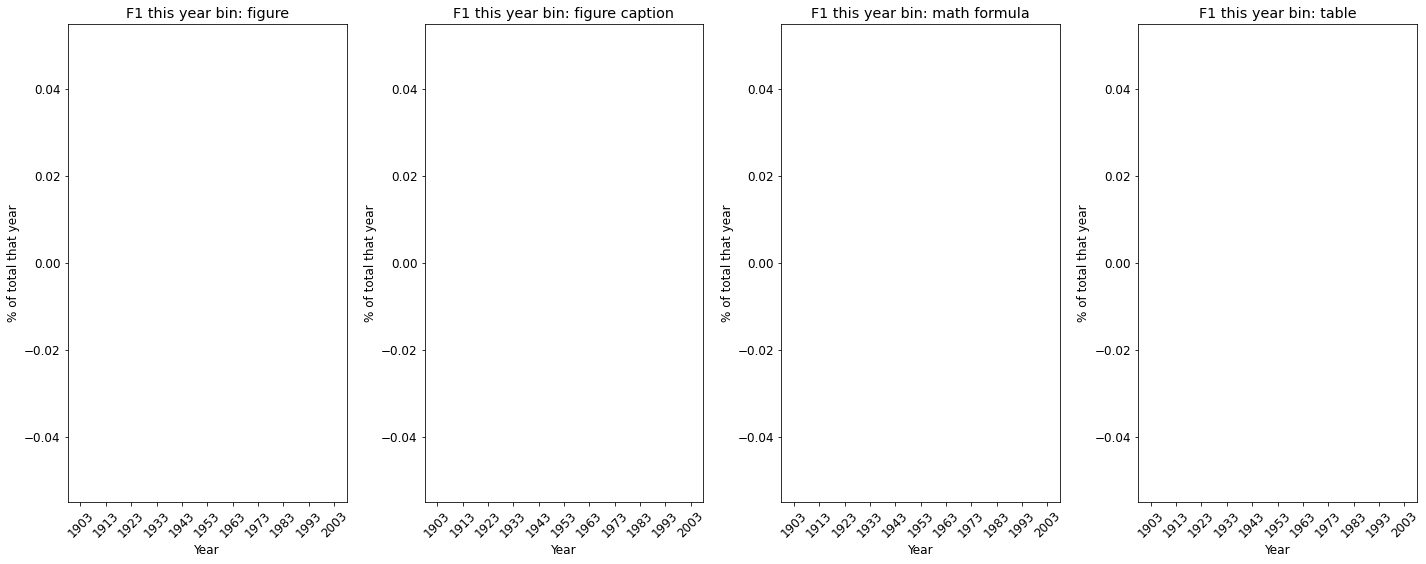

In [54]:
# loop and plot
qname = 'F1:'
bname = 'total:'
qlabel = 'F1'
fig, ax = plt.subplots(1,len(LABELS), figsize=(20,8))
matplotlib.rcParams.update({'font.size': 12})

for il,l in enumerate(LABELS):
    tp = pd.Series(index=df['years'],data=np.array(df['TP:'+l])).resample(sampleHist).sum()
    fp = pd.Series(index=df['years'],data=np.array(df['FP:'+l])).resample(sampleHist).sum()
    fn = pd.Series(index=df['years'],data=np.array(df['FN:'+l])).resample(sampleHist).sum()
    p = tp/(tp+fp); r = tp/(tp+fn)
    quant = 100*(2.0*r*p)/(r+p)
    quant.plot(kind='bar',ax=ax[il])
    ax[il].set_xticklabels([x.strftime("%Y") for x in quant.index], rotation=45)
    ax[il].set_title(qlabel+' this year bin: ' + l)
    ax[il].set_ylabel('% of total that year')
    ax[il].set_xlabel('Year')
    
plt.tight_layout()
plt.show()

Some other metrics:

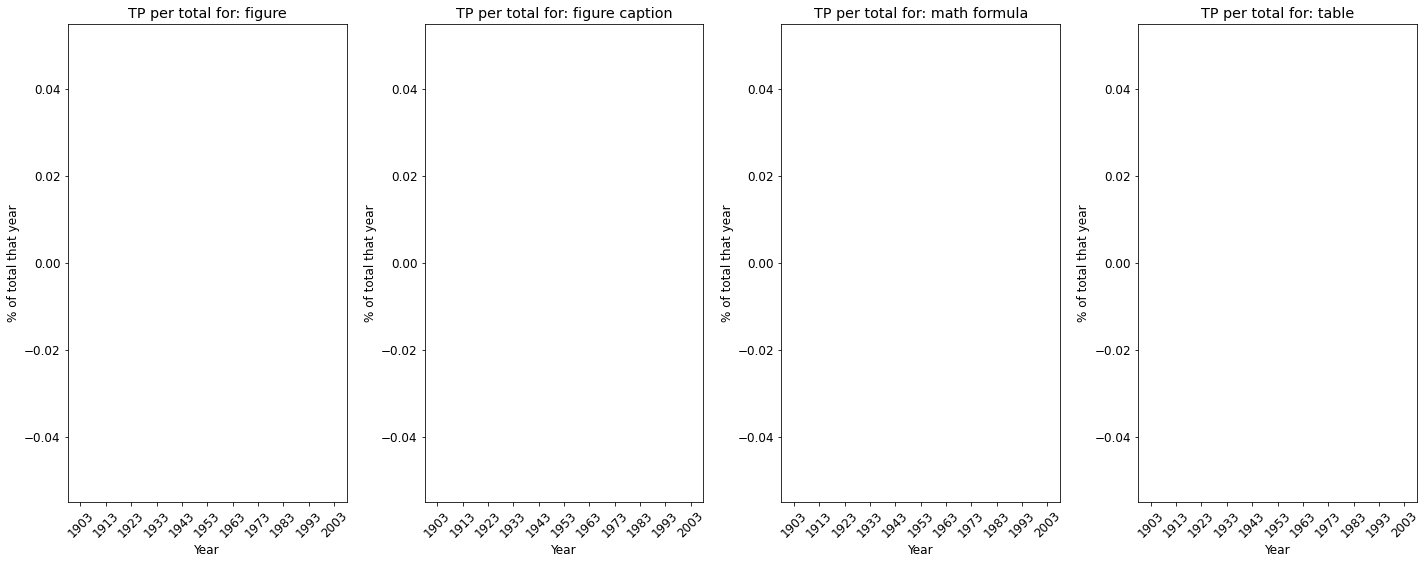

In [55]:
# loop and plot
qname = 'TP:'
bname = 'total:'
qlabel = 'TP'
fig, ax = plt.subplots(1,len(LABELS), figsize=(20,8))
matplotlib.rcParams.update({'font.size': 12})

for il,l in enumerate(LABELS):
    counts = pd.Series(index=df['years'],data=np.array(df[qname+l])).resample(sampleHist).sum()
    tot = pd.Series(index=df['years'],data=np.array(df[bname+l])).resample(sampleHist).sum()
    with np.errstate(invalid='ignore'): # take care of zeros later
        quant = pd.Series(index=tot.index,data=np.array(100*counts.values/tot.values))
    
    quant.plot(kind='bar',ax=ax[il])
    ax[il].set_xticklabels([x.strftime("%Y") for x in quant.index], rotation=45)
    ax[il].set_title(qlabel+' per total for: ' + l)
    ax[il].set_ylabel('% of total that year')
    ax[il].set_xlabel('Year')
#plt.show()
plt.tight_layout()
#plt.savefig(saveFigDir+'yolo_noOCR_truePositives_per_year.png')

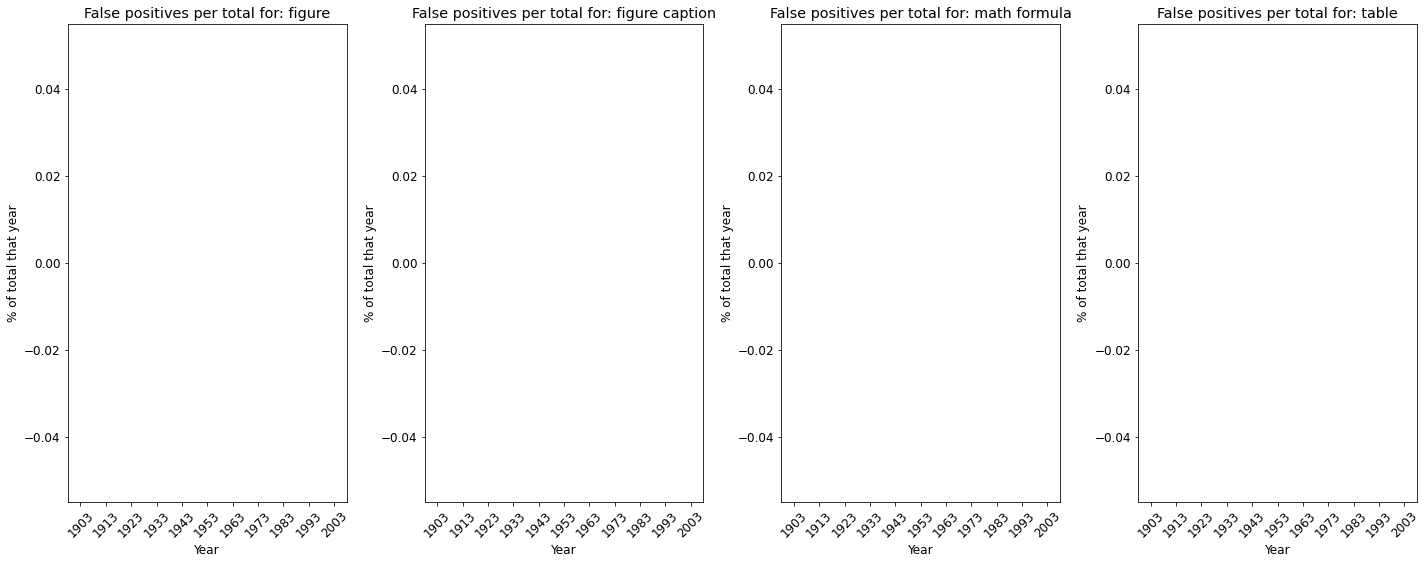

In [56]:
# loop and plot
qname = 'FP:'
bname = 'total:'
qlabel = 'False positives'
#fig, ax = plt.subplots(1,len(LABELS), figsize=(20,8))
fig, ax = plt.subplots(1,len(LABELS), figsize=(20,8))
matplotlib.rcParams.update({'font.size': 12})

for il,l in enumerate(LABELS):
    counts = pd.Series(index=df['years'],data=np.array(df[qname+l])).resample(sampleHist).sum()
    tot = pd.Series(index=df['years'],data=np.array(df[bname+l])).resample(sampleHist).sum()
    with np.errstate(invalid='ignore'): # take care of zeros later
        quant = pd.Series(index=tot.index,data=np.array(100*counts.values/tot.values))
    
    quant.plot(kind='bar',ax=ax[il])
    ax[il].set_xticklabels([x.strftime("%Y") for x in quant.index], rotation=45)
    ax[il].set_title(qlabel+' per total for: ' + l)
    ax[il].set_ylabel('% of total that year')
    ax[il].set_xlabel('Year')
    
plt.tight_layout()
plt.show()

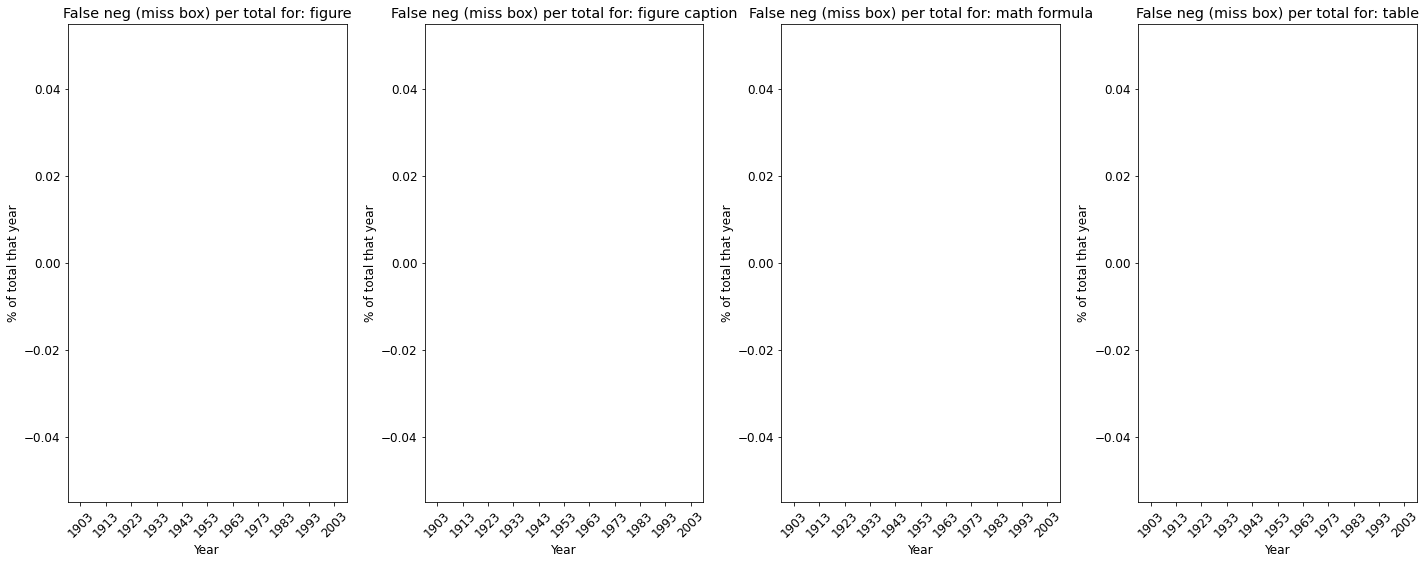

In [57]:
# loop and plot
qname = 'FN:'
bname = 'total:'
qlabel = 'False neg (miss box)'
fig, ax = plt.subplots(1,len(LABELS), figsize=(20,8))

for il,l in enumerate(LABELS):
    counts = pd.Series(index=df['years'],data=np.array(df[qname+l])).resample(sampleHist).sum()
    tot = pd.Series(index=df['years'],data=np.array(df[bname+l])).resample(sampleHist).sum()
    with np.errstate(invalid='ignore'): # take care of zeros later
        quant = pd.Series(index=tot.index,data=np.array(100*counts.values/tot.values))
    
    quant.plot(kind='bar',ax=ax[il])
    ax[il].set_xticklabels([x.strftime("%Y") for x in quant.index], rotation=45)
    ax[il].set_title(qlabel+' per total for: ' + l)
    ax[il].set_ylabel('% of total that year')
    ax[il].set_xlabel('Year')
plt.tight_layout()
plt.show()

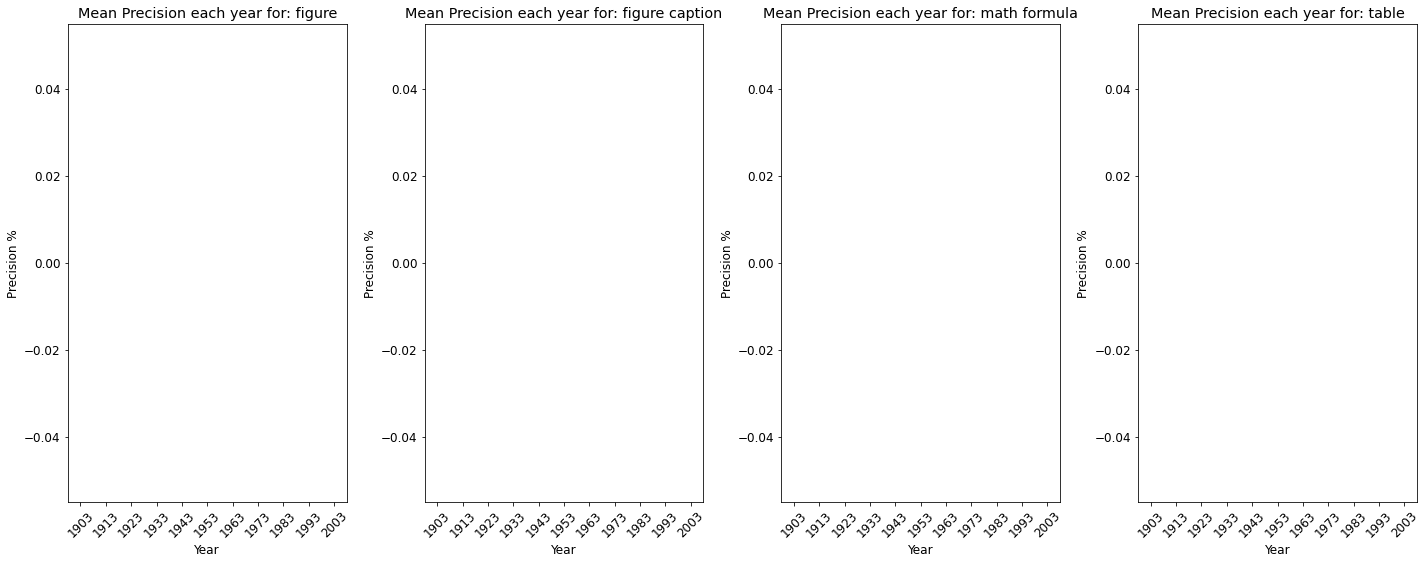

In [58]:
# loop and plot
fig, ax = plt.subplots(1,len(LABELS), figsize=(20,8))

for il,l in enumerate(LABELS):
    p = tp/(tp+fp); 
    quant = 100*p
    
    quant.plot(kind='bar',ax=ax[il])
    ax[il].set_xticklabels([x.strftime("%Y") for x in quant.index], rotation=45)
    ax[il].set_title('Mean Precision each year for: ' + l)
    ax[il].set_ylabel('Precision %')
    ax[il].set_xlabel('Year')
plt.tight_layout()
plt.show()

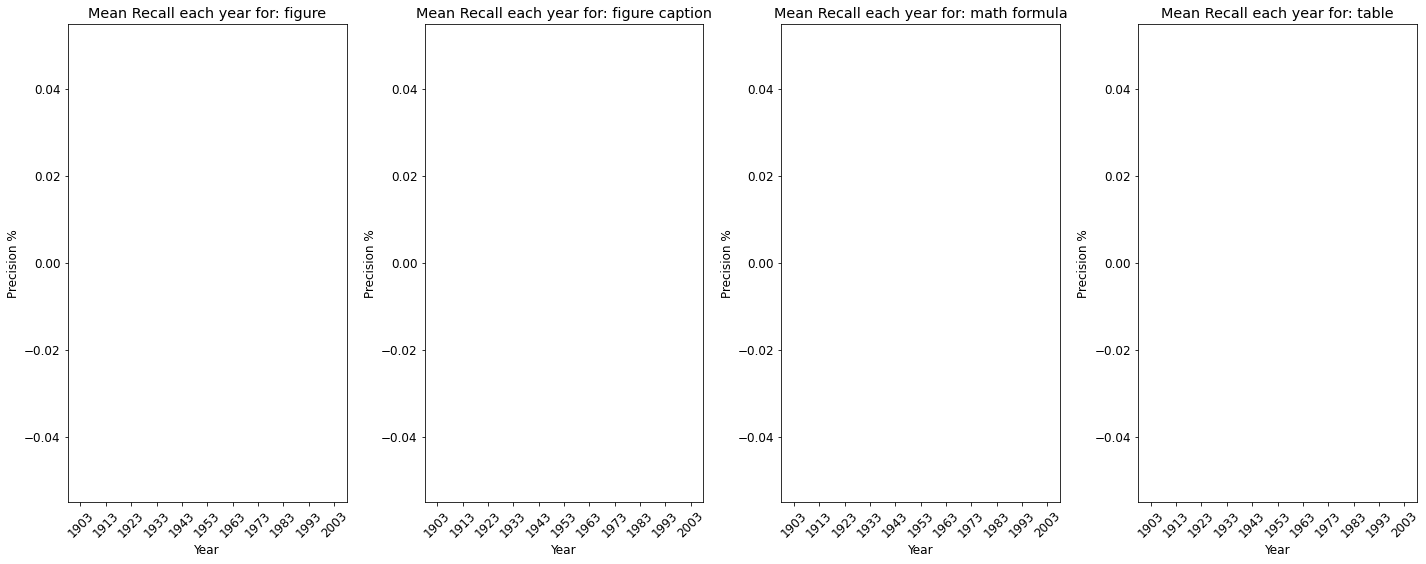

In [59]:
# loop and plot
fig, ax = plt.subplots(1,len(LABELS), figsize=(20,8))

for il,l in enumerate(LABELS):
    r = tp/(tp+fn)
    quant = 100*r
    
    quant.plot(kind='bar',ax=ax[il])
    ax[il].set_xticklabels([x.strftime("%Y") for x in quant.index], rotation=45)
    ax[il].set_title('Mean Recall each year for: ' + l)
    ax[il].set_ylabel('Precision %')
    ax[il].set_xlabel('Year')
plt.tight_layout()
plt.show()

## Save to .dat files if requested

In [60]:
import os

adder_dats += adder_here

In [61]:
if save_dats:
    # save too
    #out_num_name = binary_dirs.split('/')[0]+adder_dats
    out_num_name = adder_dats
    num_out_file = config.save_table_dats_dir + out_num_name
    #ioumin_per_labels = [0.1, 0.6, 0.8, 0.9, 0.95]
    #if out_num_name != 'main':
    if not os.path.exists(num_out_file+'/'):
        os.makedirs(num_out_file+'/')
    ioumin_per_labels = ioustar # just the one for our decisions
    num_out_file += '/' + out_num_name
    # how many labels to save up to?
    lend = 2

    # save to file
    with open(num_out_file + '_score.dat','w') as fnum:
        print(scorestar, file=fnum, end='')
    with open(num_out_file + '_ncv.dat','w') as fnum:
        print(n_folds_cv, file=fnum, end='')


    TPv, FPv, FNv, totalTruev = calc_base_metrics_allboxes_cv(LABELS,[scorestar],ioustar,
                                                  trueshere,boxes_fb,labels_fb, 
                                              scores_fb,n_folds_cv=n_folds_cv,
                                                             seed=seed)

    precision, precision_std, recall, \
      recall_std, f1, f1_std = calc_prec_rec_f1_cv(TPv,FPv,FNv,
                                                   LABELS,[scorestar],
                                                   ioustar)


    # print out total true
    for il,m in enumerate(totalTruev[:lend].sum(axis=-1)):
        with open(num_out_file + '_totTrue_'+LABELS[il].replace(' ','_')+'.dat','w') as fnum:
            print(int(m), file=fnum, end='')

    # print out TP
    for ii,iou in enumerate(ioustar):
        iouhere = str(iou).replace('.','p')

        TP = TPv[:,0,ii,:].sum(axis=-1)
        FP = FPv[:,0,ii,:].sum(axis=-1)
        FN = FNv[:,0,ii,:].sum(axis=-1)

        for il,m in enumerate(TP[:lend]):
            dat = str(round(m/totalTrue[il]*100,1))
            with open(num_out_file + '_TP_'+LABELS[il].replace(' ','_')+'_iou'+iouhere+'.dat','w') as fnum:
                print(dat, file=fnum, end='')

        for il,m in enumerate(FP[:lend]):
            dat = str(round(m/totalTrue[il]*100,1))
            with open(num_out_file + '_FP_'+LABELS[il].replace(' ','_')+'_iou'+iouhere+'.dat','w') as fnum:
                print(dat, file=fnum, end='')

        for il,m in enumerate(FN[:lend]):
            dat = str(round(m/totalTrue[il]*100,1))
            with open(num_out_file + '_FN_'+LABELS[il].replace(' ','_')+'_iou'+iouhere+'.dat','w') as fnum:
                print(dat, file=fnum, end='')

        for il,m in enumerate(LABELS[:lend]):
            dat = str(np.round(precision[il,0,ii],1))+'$\pm$' +str(np.round(precision_std[il,0,ii],1))
            with open(num_out_file + '_prec_'+LABELS[il].replace(' ','_')+'_iou'+iouhere+'.dat','w') as fnum:
                print(dat, file=fnum, end='')

        for il,m in enumerate(LABELS[:lend]):
            dat = str(np.round(recall[il,0,ii],1))+'$\pm$' +str(np.round(recall_std[il,0,ii],1))
            with open(num_out_file + '_rec_'+LABELS[il].replace(' ','_')+'_iou'+iouhere+'.dat','w') as fnum:
                print(dat, file=fnum, end='')

        for il,m in enumerate(LABELS[:lend]):
            dat = str(np.round(f1[il,0,ii],1))+'$\pm$' +str(np.round(f1_std[il,0,ii],1))
            with open(num_out_file + '_f1_'+LABELS[il].replace(' ','_')+'_iou'+iouhere+'.dat','w') as fnum:
                print(dat, file=fnum, end='')


In [62]:
adder_dats

'fbdetect'

detectron2 with our post-processing:

In [63]:
adder_dats_pp = adder_dats + '_withPP'

if save_dats:
    # save too
    out_num_name = adder_dats_pp
    num_out_file = config.save_table_dats_dir + out_num_name
    #ioumin_per_labels = [0.1, 0.6, 0.8, 0.9, 0.95]
    #if out_num_name != 'main':
    if not os.path.exists(num_out_file+'/'):
        os.makedirs(num_out_file+'/')
    ioumin_per_labels = ioustar # just the one for our decisions
    num_out_file += '/' + out_num_name
    # how many labels to save up to?
    lend = 2

    # save to file
    with open(num_out_file + '_score.dat','w') as fnum:
        print(scorestar, file=fnum, end='')
    with open(num_out_file + '_ncv.dat','w') as fnum:
        print(n_folds_cv, file=fnum, end='')


    TPv, FPv, FNv, totalTruev = calc_base_metrics_allboxes_cv(LABELS,[scorestar],ioustar,
                                                  trueshere_pp,boxes_fb_pp,labels_fb_pp, 
                                              scores_fb_pp,n_folds_cv=n_folds_cv,
                                                             seed=seed)

    precision, precision_std, recall, \
      recall_std, f1, f1_std = calc_prec_rec_f1_cv(TPv,FPv,FNv,
                                                   LABELS,[scorestar],
                                                   ioustar)


    # print out total true
    for il,m in enumerate(totalTruev[:lend].sum(axis=-1)):
        with open(num_out_file + '_totTrue_'+LABELS[il].replace(' ','_')+'.dat','w') as fnum:
            print(int(m), file=fnum, end='')

    # print out TP
    for ii,iou in enumerate(ioustar):
        iouhere = str(iou).replace('.','p')

        TP = TPv[:,0,ii,:].sum(axis=-1)
        FP = FPv[:,0,ii,:].sum(axis=-1)
        FN = FNv[:,0,ii,:].sum(axis=-1)

        for il,m in enumerate(TP[:lend]):
            dat = str(round(m/totalTrue[il]*100,1))
            with open(num_out_file + '_TP_'+LABELS[il].replace(' ','_')+'_iou'+iouhere+'.dat','w') as fnum:
                print(dat, file=fnum, end='')

        for il,m in enumerate(FP[:lend]):
            dat = str(round(m/totalTrue[il]*100,1))
            with open(num_out_file + '_FP_'+LABELS[il].replace(' ','_')+'_iou'+iouhere+'.dat','w') as fnum:
                print(dat, file=fnum, end='')

        for il,m in enumerate(FN[:lend]):
            dat = str(round(m/totalTrue[il]*100,1))
            with open(num_out_file + '_FN_'+LABELS[il].replace(' ','_')+'_iou'+iouhere+'.dat','w') as fnum:
                print(dat, file=fnum, end='')

        for il,m in enumerate(LABELS[:lend]):
            dat = str(np.round(precision[il,0,ii],1))+'$\pm$' +str(np.round(precision_std[il,0,ii],1))
            with open(num_out_file + '_prec_'+LABELS[il].replace(' ','_')+'_iou'+iouhere+'.dat','w') as fnum:
                print(dat, file=fnum, end='')

        for il,m in enumerate(LABELS[:lend]):
            dat = str(np.round(recall[il,0,ii],1))+'$\pm$' +str(np.round(recall_std[il,0,ii],1))
            with open(num_out_file + '_rec_'+LABELS[il].replace(' ','_')+'_iou'+iouhere+'.dat','w') as fnum:
                print(dat, file=fnum, end='')

        for il,m in enumerate(LABELS[:lend]):
            dat = str(np.round(f1[il,0,ii],1))+'$\pm$' +str(np.round(f1_std[il,0,ii],1))
            with open(num_out_file + '_f1_'+LABELS[il].replace(' ','_')+'_iou'+iouhere+'.dat','w') as fnum:
                print(dat, file=fnum, end='')

In [64]:
# import os

In [65]:
#adder_dats2 = 'nopost2'

In [66]:
# if save_dats:
#     # save too
#     #out_num_name = binary_dirs.split('/')[0]+adder_dats
#     out_num_name = adder_dats2
#     num_out_file = config.save_table_dats_dir + out_num_name
#     #ioumin_per_labels = [0.1, 0.6, 0.8, 0.9, 0.95]
#     #if out_num_name != 'main':
#     if not os.path.exists(num_out_file+'/'):
#         os.makedirs(num_out_file+'/')
#     ioumin_per_labels = ioustar # just the one for our decisions
#     num_out_file += '/' + out_num_name
#     # how many labels to save up to?
#     lend = 2

#     # save to file
#     with open(num_out_file + '_score.dat','w') as fnum:
#         print(scorestar, file=fnum, end='')
#     with open(num_out_file + '_ncv.dat','w') as fnum:
#         print(n_folds_cv, file=fnum, end='')

#     TPv, FPv, FNv, totalTruev = calc_base_metrics_allboxes_cv(LABELS,[scorestar],ioustar,
#                                                   truebox,boxes1,labels1, 
#                                                scores1,n_folds_cv=n_folds_cv,
#                                                              seed=seed)

#     precision, precision_std, recall, \
#       recall_std, f1, f1_std = calc_prec_rec_f1_cv(TPv,FPv,FNv,
#                                                    LABELS,[scorestar],
#                                                    ioustar)


#     # print out total true
#     for il,m in enumerate(totalTruev[:lend].sum(axis=-1)):
#         with open(num_out_file + '_totTrue_'+LABELS[il].replace(' ','_')+'.dat','w') as fnum:
#             print(int(m), file=fnum, end='')

#     # print out TP
#     for ii,iou in enumerate(ioustar):
#         iouhere = str(iou).replace('.','p')

#         TP = TPv[:,0,ii,:].sum(axis=-1)
#         FP = FPv[:,0,ii,:].sum(axis=-1)
#         FN = FNv[:,0,ii,:].sum(axis=-1)

#         for il,m in enumerate(TP[:lend]):
#             dat = str(round(m/totalTrue[il]*100,1))
#             with open(num_out_file + '_TP_'+LABELS[il].replace(' ','_')+'_iou'+iouhere+'.dat','w') as fnum:
#                 print(dat, file=fnum, end='')

#         for il,m in enumerate(FP[:lend]):
#             dat = str(round(m/totalTrue[il]*100,1))
#             with open(num_out_file + '_FP_'+LABELS[il].replace(' ','_')+'_iou'+iouhere+'.dat','w') as fnum:
#                 print(dat, file=fnum, end='')

#         for il,m in enumerate(FN[:lend]):
#             dat = str(round(m/totalTrue[il]*100,1))
#             with open(num_out_file + '_FN_'+LABELS[il].replace(' ','_')+'_iou'+iouhere+'.dat','w') as fnum:
#                 print(dat, file=fnum, end='')

#         for il,m in enumerate(LABELS[:lend]):
#             dat = str(np.round(precision[il,0,ii],1))+'$\pm$' +str(np.round(precision_std[il,0,ii],1))
#             with open(num_out_file + '_prec_'+LABELS[il].replace(' ','_')+'_iou'+iouhere+'.dat','w') as fnum:
#                 print(dat, file=fnum, end='')

#         for il,m in enumerate(LABELS[:lend]):
#             dat = str(np.round(recall[il,0,ii],1))+'$\pm$' +str(np.round(recall_std[il,0,ii],1))
#             with open(num_out_file + '_rec_'+LABELS[il].replace(' ','_')+'_iou'+iouhere+'.dat','w') as fnum:
#                 print(dat, file=fnum, end='')

#         for il,m in enumerate(LABELS[:lend]):
#             dat = str(np.round(f1[il,0,ii],1))+'$\pm$' +str(np.round(f1_std[il,0,ii],1))
#             with open(num_out_file + '_f1_'+LABELS[il].replace(' ','_')+'_iou'+iouhere+'.dat','w') as fnum:
#                 print(dat, file=fnum, end='')

In [67]:
#adder_dats2